# **Q9. OLA - Ensemble Learning**

## **Problem Statement:**
### 1. Help OLA to understand what factors are important in predicting possible attrition of drivers and how these factors are interrelated among themselves.

In [3]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, precision_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer, SimpleImputer
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import missingno as msno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]

In [8]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<5:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<5:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [9]:
def remove_outlier(df_in, col_name, thresh=5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        if round(outlier_fraction*100, 2) < 100.00:
            fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
            sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= thresh/100:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            if round(outlier_fraction*100, 2) < 100.00:
                fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
                plt.show()
            return df_in
    else:
        return df_in

In [10]:
def vif_pruning(features, vif_threshold):
    vifs = []
    columns = []
    result = []
    feature_columns = features.columns
    for column in feature_columns:
        if len(features.columns) <=1:
            vifs += [0]
            columns += [column]
            result += ["Keeping column"]
            break
        vif = round(variance_inflation_factor(features.values, features.columns.get_loc(column)), 2)
        vifs += [vif]
        columns += [column]
        if vif > vif_threshold:
            features = features.drop(column, axis=1)
            result += ["Dropping column"]
        else:
            result += ["Keeping column"]
    return features, pd.DataFrame({'VIF Score':vifs, 'Column Name':columns, 'Result':result})

***
***
## **1. Analyzing Basic Metrics.**

In [11]:
filename = 'data.csv'
df = pd.read_csv(filename)

In [7]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [12]:
df.shape

(396030, 27)

***
***
## **2. Missing Value detection and treatment.**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


***
### Analyzing missing Age values.

In [10]:
drivers_missing_age = df[df['Age'].isnull()]['Driver_ID']

In [11]:
df[df['Driver_ID'].isin(drivers_missing_age)].head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
68,68,10/01/19,20,26.0,1.0,C19,0,40342,25/10/19,NaN,3,3,0,1
69,69,11/01/19,20,26.0,1.0,C19,0,40342,25/10/19,NaN,3,3,0,1
70,70,12/01/19,20,26.0,1.0,C19,0,40342,25/10/19,NaN,3,3,0,1
71,71,01/01/20,20,26.0,1.0,C19,0,40342,25/10/19,NaN,3,3,0,1
72,72,02/01/20,20,NaN,1.0,C19,0,40342,25/10/19,NaN,3,3,0,1


***
### As we can see, some records for some drivers don't have Age details mentioned, but the remaining records for the same driver will have correct Age details. So, no need to use any imputation technique on Age column as we are anyway going to group on Driver_ID column and pick non-null Age value.

***
### Analyzing missing Gender values.

In [12]:
drivers_missing_gender = df[df['Gender'].isnull()]['Driver_ID']

In [13]:
df[df['Driver_ID'].isin(drivers_missing_gender)].head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
239,239,01/01/19,43,27.0,1.0,C15,0,12906,13/07/18,NaN,1,1,359890,1
240,240,02/01/19,43,27.0,NaN,C15,0,12906,13/07/18,20/02/19,1,1,0,1
257,257,01/01/19,49,21.0,0.0,C20,0,53039,25/05/18,NaN,1,2,171760,1
258,258,02/01/19,49,21.0,NaN,C20,0,53039,25/05/18,NaN,1,2,0,1
259,259,03/01/19,49,21.0,0.0,C20,0,53039,25/05/18,NaN,1,2,392890,1


***
### As we can see, some records for some drivers don't have Gender details mentioned, but the remaining records for the same driver will have correct Gender details. So, no need to use any imputation technique on Gender column as we are anyway going to group on Driver_ID column and pick non-null Gender value.

***
***
## **3. Merging records for each driver and new Feature Creation.**

In [14]:
df = df.drop(df.columns[0], axis=1)
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])
df['City'] = df['City'].astype('string')
df.sort_values(by=['Driver_ID', 'MMM-YY'], ascending=True)
df.dtypes

MMM-YY                  datetime64[ns]
Driver_ID                        int64
Age                            float64
Gender                         float64
City                            string
Education_Level                  int64
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Grade                            int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [15]:
df = df.groupby('Driver_ID').agg(reporting_start_date=('MMM-YY', 'min'),
                           reporting_end_date=('MMM-YY', 'max'),
                            age=('Age', 'max'),
                            gender=('Gender', 'max'),
                            city=('City', 'max'),
                            education=('Education_Level', 'max'),
                            start_monthly_income=('Income', 'first'),
                            end_monthly_income=('Income', 'last'),
                            joining_date=('Dateofjoining', 'max'),
                            exit_date=('LastWorkingDate', 'max'),
                            designation=('Joining Designation', 'max'),
                            start_grade=('Grade', 'first'),
                            end_grade=('Grade', 'last'),
                            total_business=('Total Business Value', 'sum'),
                            start_rating=('Quarterly Rating', 'first'),
                            end_rating=('Quarterly Rating', 'last')
                           ).reset_index()

In [16]:
df['income_raised'] = ((df['end_monthly_income'] - df['start_monthly_income'])>0).astype('int64')
df['grade_raised'] = ((df['end_grade'] - df['start_grade'])>0).astype('int64')
df['rating_raised'] = ((df['end_rating'] - df['start_rating'])>0).astype('int64')
df['has_left'] = (df['exit_date'].isnull()).astype('int64')
df['reporting_start_year'] = pd.to_datetime(df['reporting_start_date']).dt.year
df['reporting_start_month'] = pd.to_datetime(df['reporting_start_date']).dt.month
df['reporting_start_day'] = pd.to_datetime(df['reporting_start_date']).dt.day
df['reporting_end_year'] = pd.to_datetime(df['reporting_end_date']).dt.year
df['reporting_end_month'] = pd.to_datetime(df['reporting_end_date']).dt.month
df['reporting_end_day'] = pd.to_datetime(df['reporting_end_date']).dt.day
df['joining_year'] = pd.to_datetime(df['joining_date']).dt.year
df['joining_month'] = pd.to_datetime(df['joining_date']).dt.month
df['joining_day'] = pd.to_datetime(df['joining_date']).dt.day
df = df.drop(['exit_date', 'reporting_start_date', 'reporting_end_date', 'joining_date', 'Driver_ID'], axis=1)

In [17]:
for column in ['gender', 'income_raised', 'grade_raised',  'rating_raised', 'has_left']:
    df[column] = pd.Categorical(df[column])

In [18]:
df.head()

,age,gender,city,education,start_monthly_income,end_monthly_income,designation,start_grade,end_grade,total_business,start_rating,end_rating,income_raised,grade_raised,rating_raised,has_left,reporting_start_year,reporting_start_month,reporting_start_day,reporting_end_year,reporting_end_month,reporting_end_day,joining_year,joining_month,joining_day
0,28.0,0.0,C23,2,57387,57387,1,1,1,1715580,2,2,0,0,0,0,2019,1,1,2019,3,1,2018,12,24
1,31.0,0.0,C7,2,67016,67016,2,2,2,0,1,1,0,0,0,1,2020,11,1,2020,12,1,2020,11,6
2,43.0,0.0,C13,2,65603,65603,2,2,2,350000,1,1,0,0,0,0,2019,12,1,2020,4,1,2019,12,7
3,29.0,0.0,C9,0,46368,46368,1,1,1,120360,1,1,0,0,0,0,2019,1,1,2019,3,1,2019,1,9
4,31.0,1.0,C11,1,78728,78728,3,3,3,1265000,1,2,0,0,1,1,2020,8,1,2020,12,1,2020,7,31


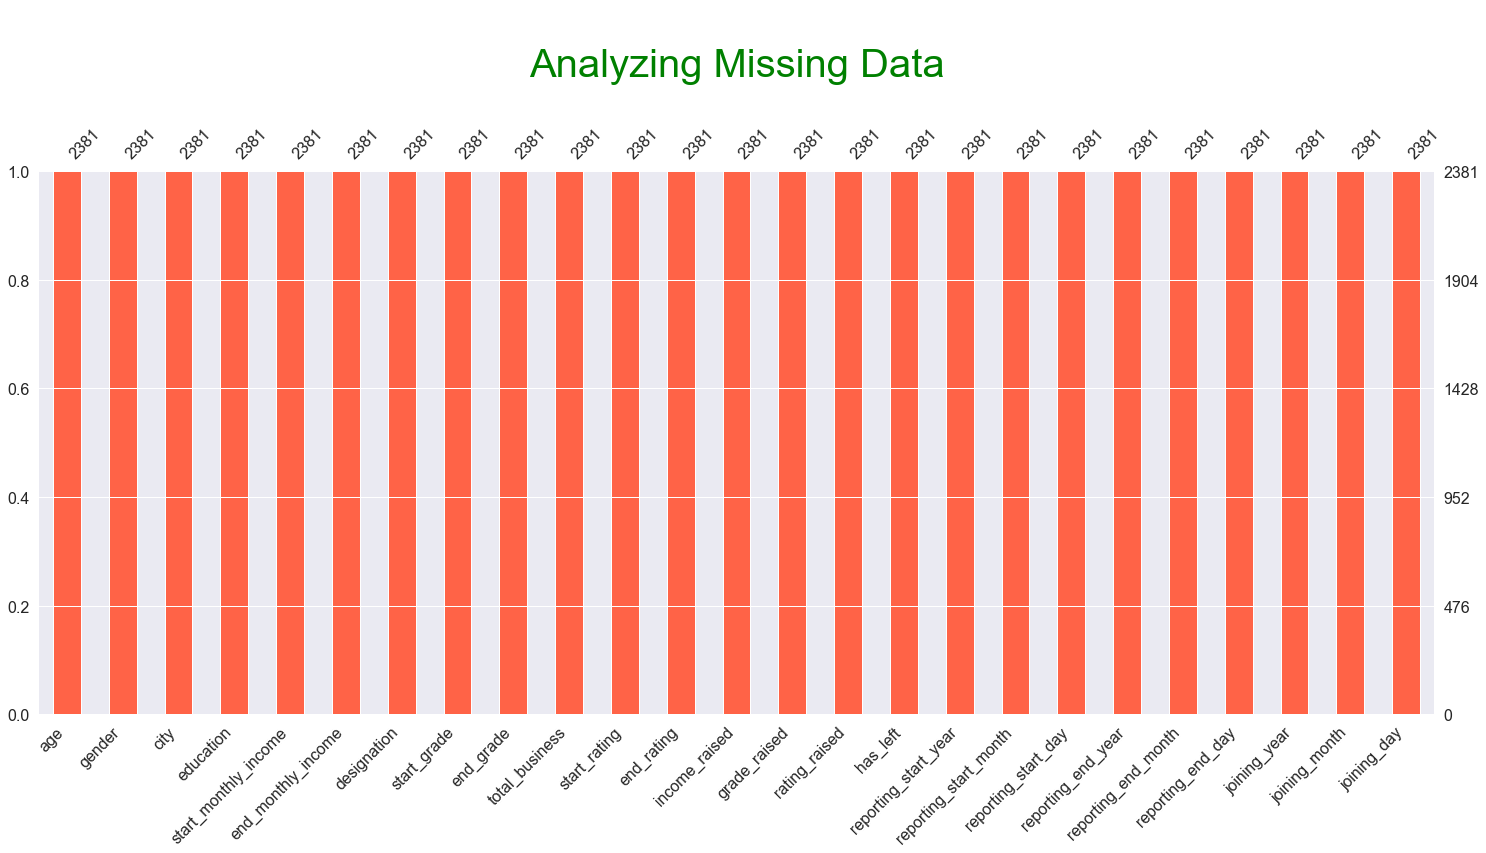

In [19]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

***
***
## **4. Outlier Detection & Treatment.**

In [20]:
df.describe()

,age,education,start_monthly_income,end_monthly_income,designation,start_grade,end_grade,total_business,start_rating,end_rating,reporting_start_year,reporting_start_month,reporting_start_day,reporting_end_year,reporting_end_month,reporting_end_day,joining_year,joining_month,joining_day
count,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.0,2381.000000,2381.000000,2381.0,2381.000000,2381.000000,2381.000000
mean,33.663167,1.00756,59209.060899,59334.157077,1.820244,2.078538,2.096598,4.586742e+06,1.486350,1.427971,2019.346493,4.791684,1.0,2019.651407,8.166737,1.0,2018.536329,7.357413,15.787484
std,5.983375,0.81629,28275.899087,28383.666384,0.841433,0.931321,0.941522,9.127115e+06,0.834348,0.809839,0.475952,4.029444,0.0,0.476625,3.893261,0.0,1.609597,3.143143,9.371835
min,21.000000,0.00000,10747.000000,10747.000000,1.000000,1.000000,1.000000,-1.385530e+06,1.000000,1.000000,2019.000000,1.000000,1.0,2019.000000,1.000000,1.0,2013.000000,1.000000,1.000000
25%,29.000000,0.00000,39104.000000,39104.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,1.000000,2019.000000,1.000000,1.0,2019.000000,5.000000,1.0,2018.000000,5.000000,7.000000
50%,33.000000,1.00000,55276.000000,55315.000000,2.000000,2.000000,2.000000,8.176800e+05,1.000000,1.000000,2019.000000,4.000000,1.0,2020.000000,9.000000,1.0,2019.000000,7.000000,15.000000
75%,37.000000,2.00000,75765.000000,75986.000000,2.000000,3.000000,3.000000,4.173650e+06,2.000000,2.000000,2020.000000,8.000000,1.0,2020.000000,12.000000,1.0,2020.000000,10.000000,24.000000
max,58.000000,2.00000,188418.000000,188418.000000,5.000000,5.000000,5.000000,9.533106e+07,4.000000,4.000000,2020.000000,12.000000,1.0,2020.000000,12.000000,1.0,2020.000000,12.000000,31.000000


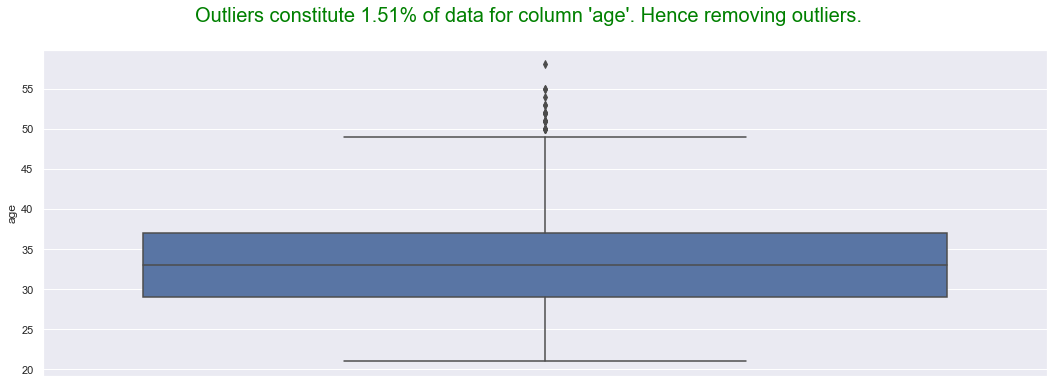

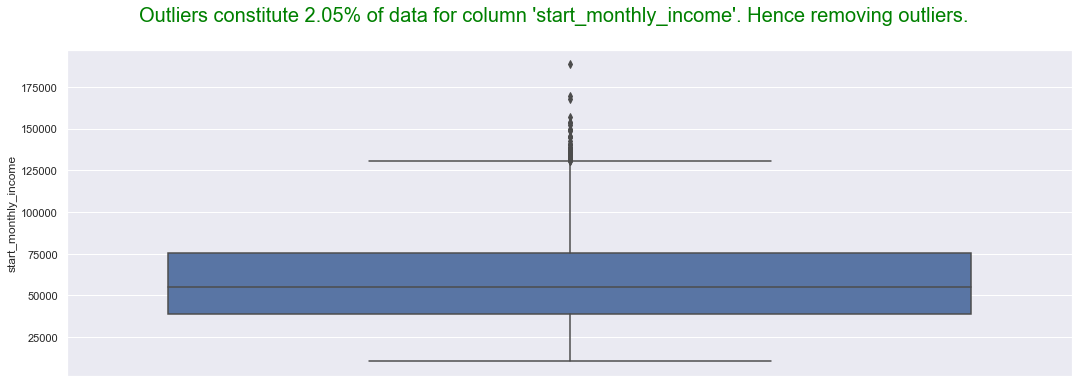

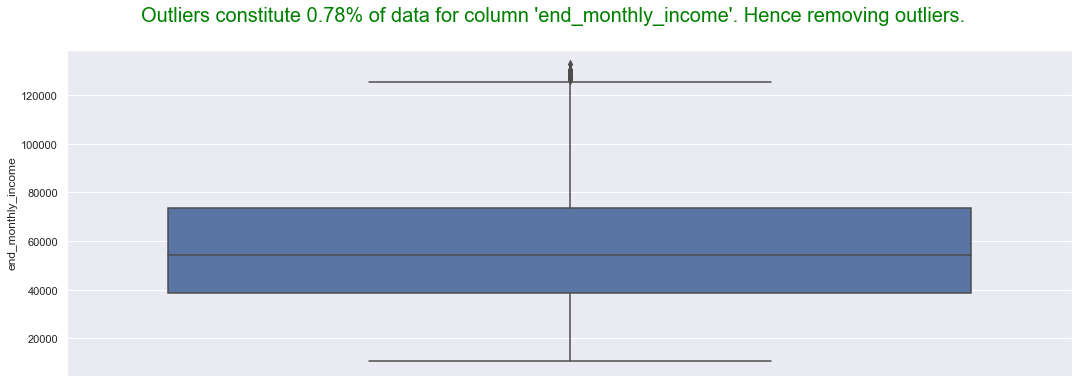

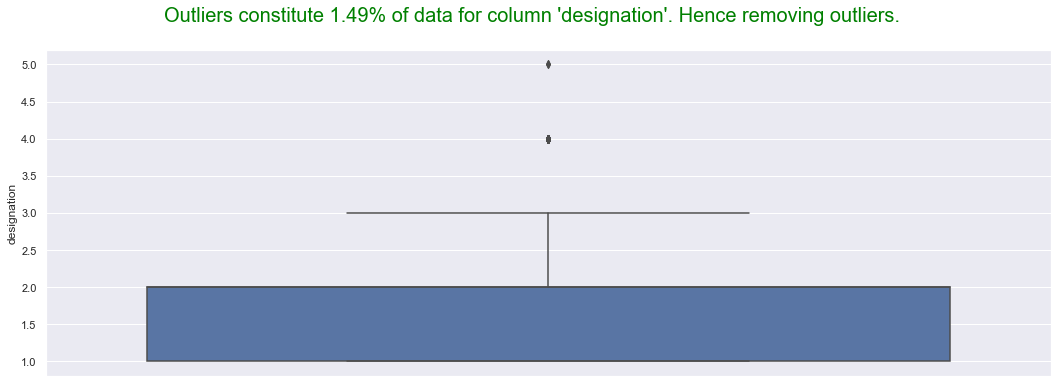

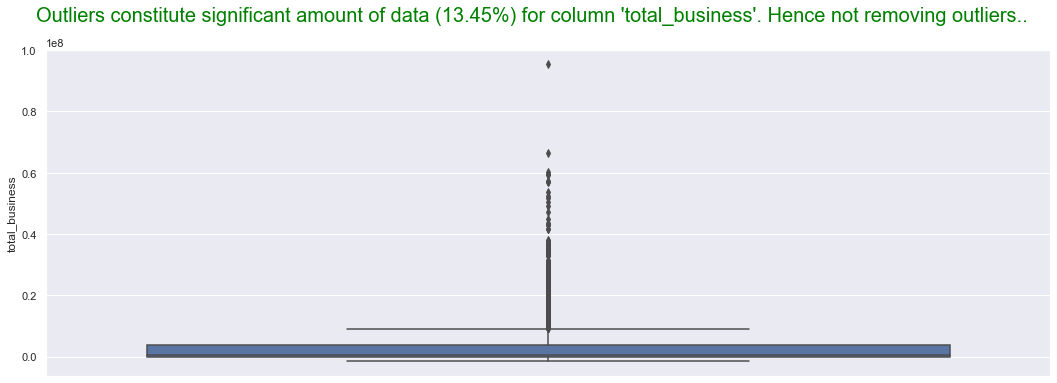

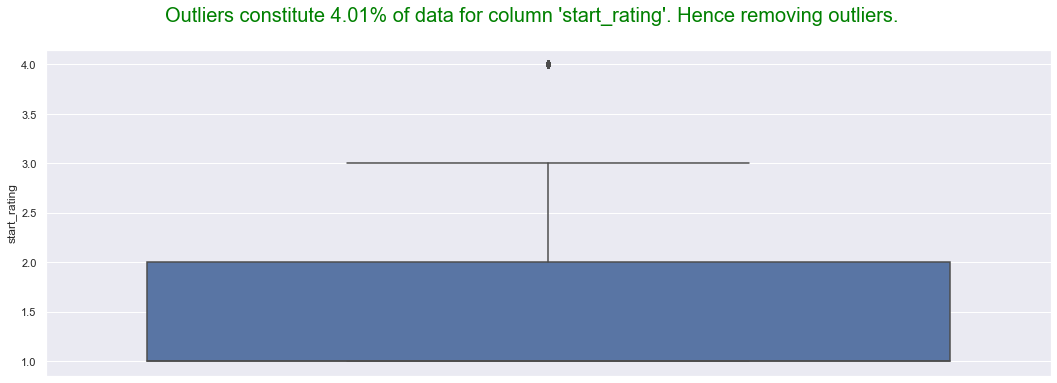

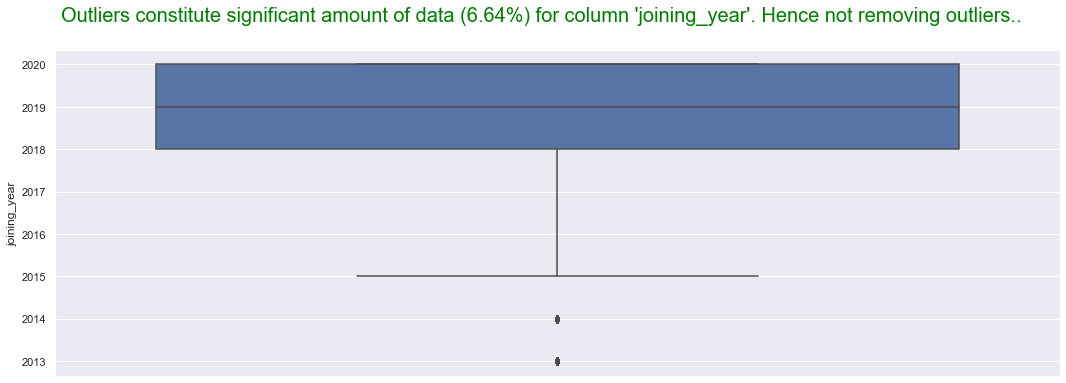

In [21]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column, thresh=5)

***
***
## **5. Univariate Analysis (Categorical Data).**

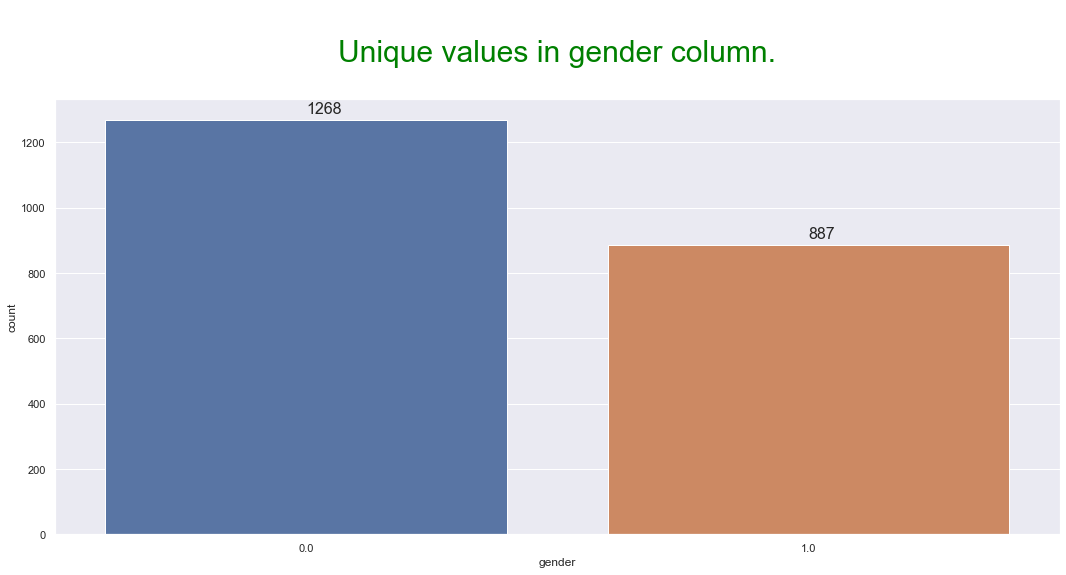

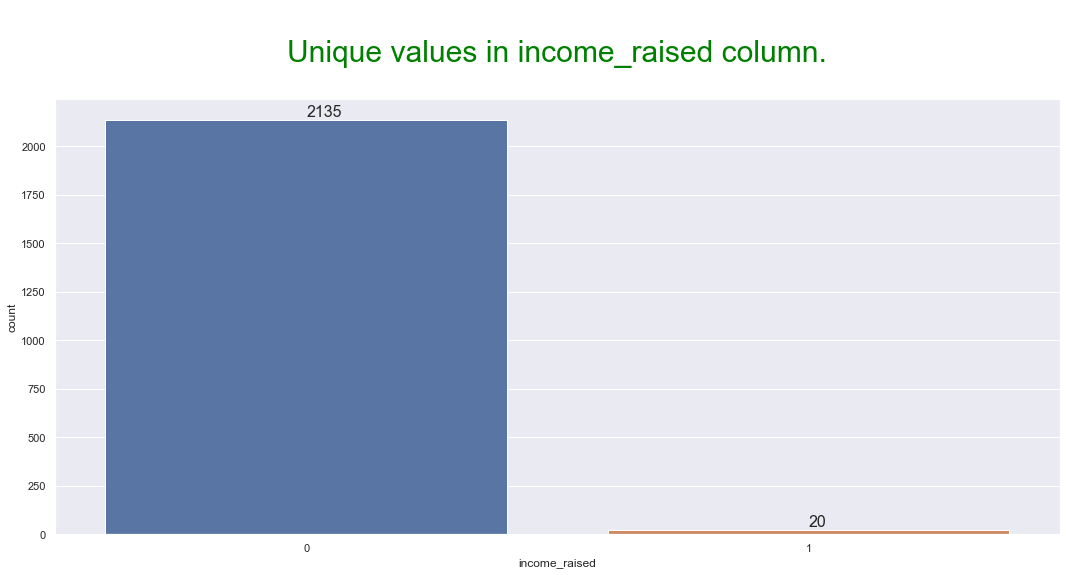

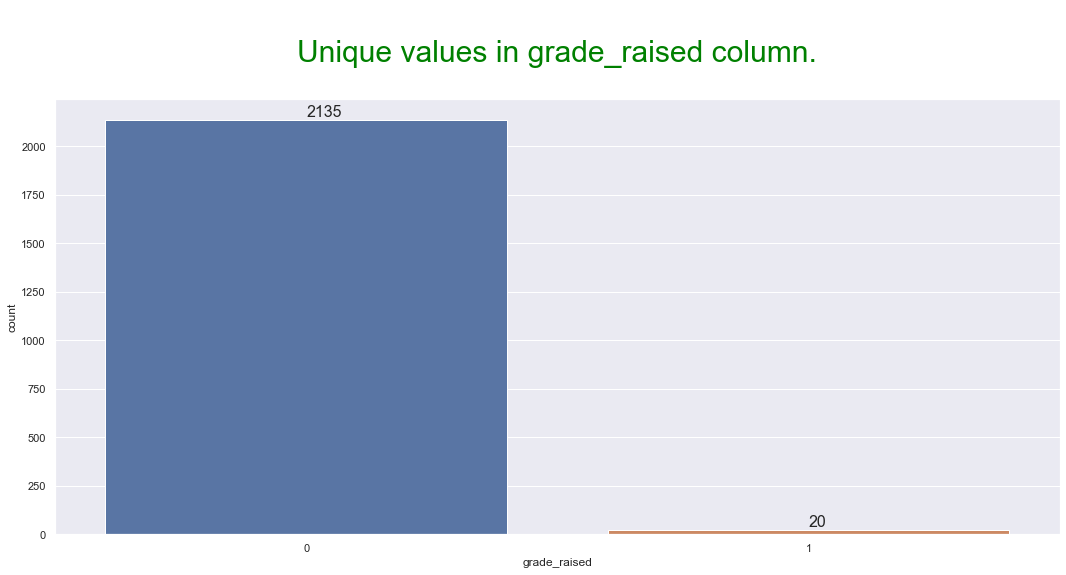

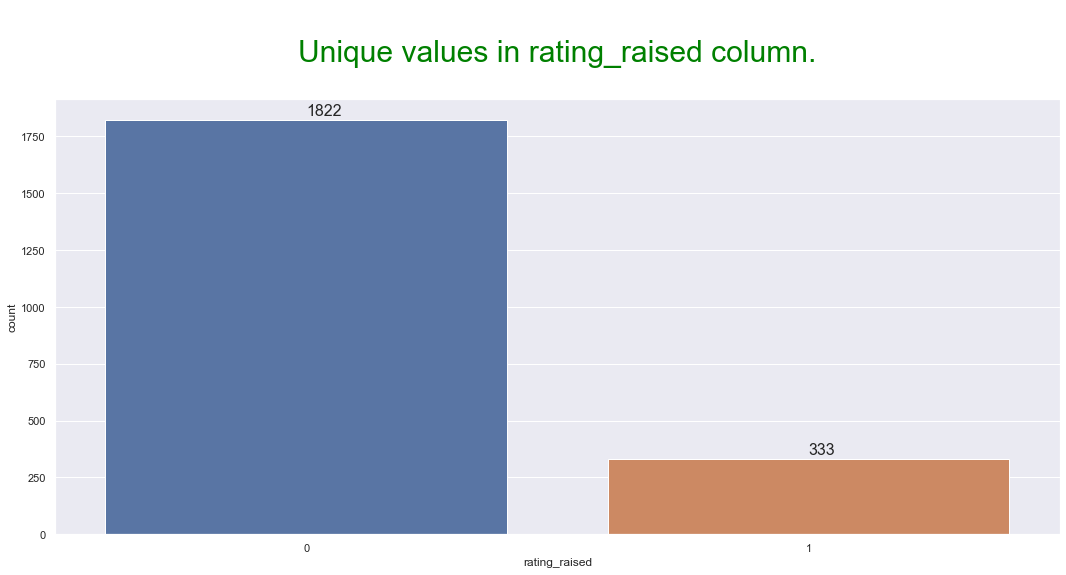

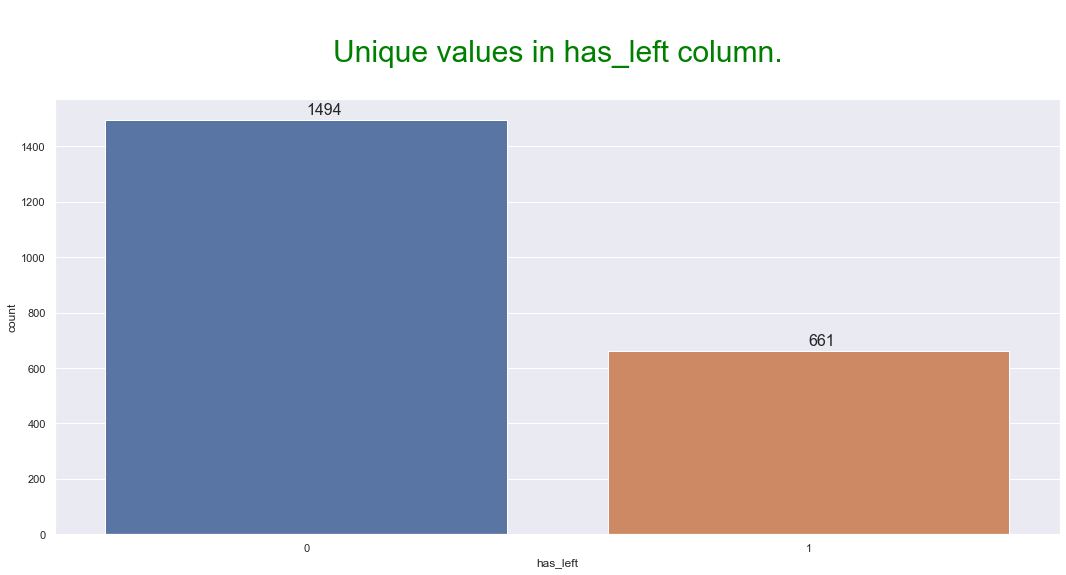

In [22]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,8))
    ax = sns.countplot(data=df, x=column)
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.40, p.get_height()+20), size=16)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Univariate Analysis (Discrete Data).**

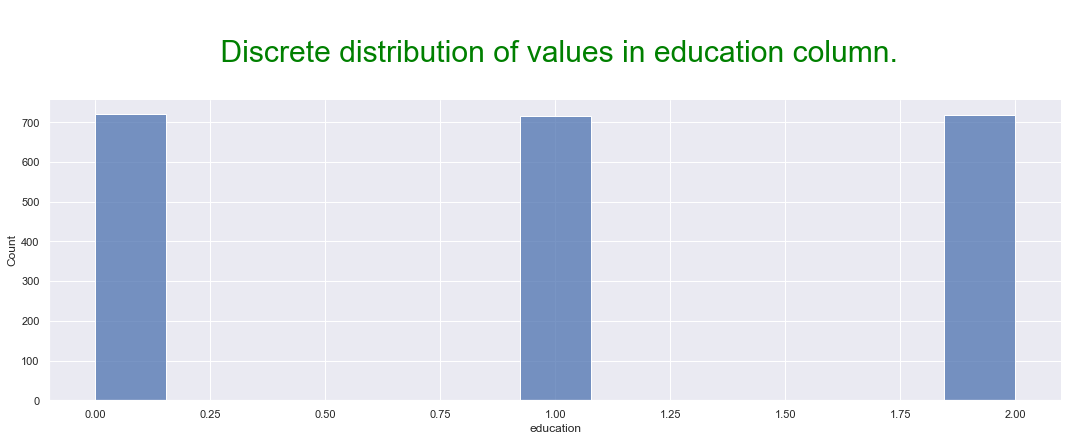

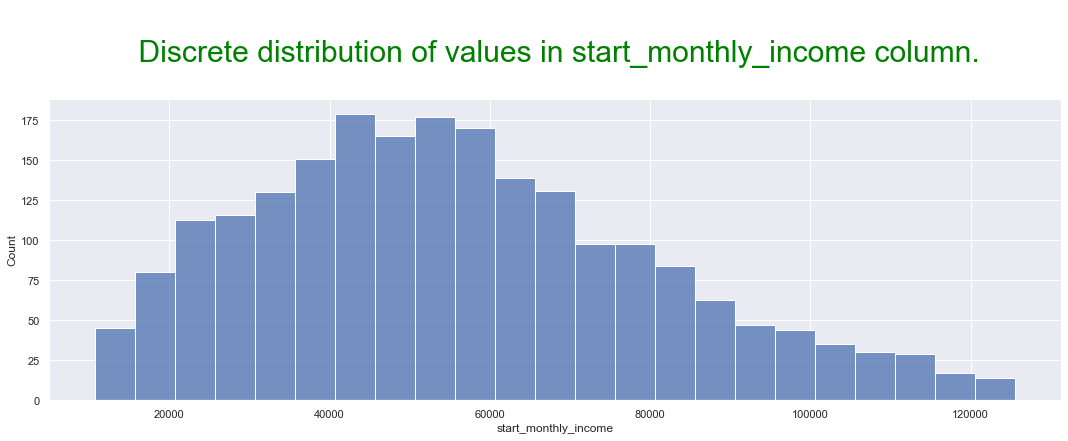

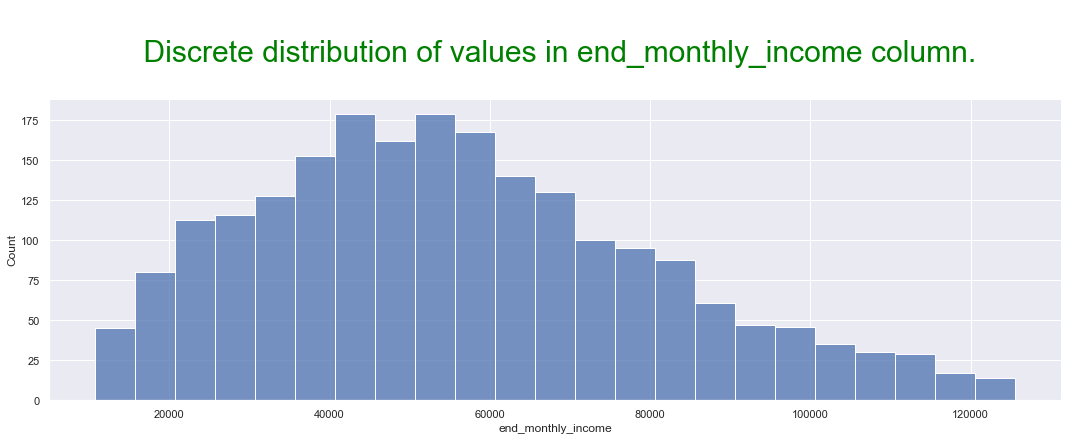

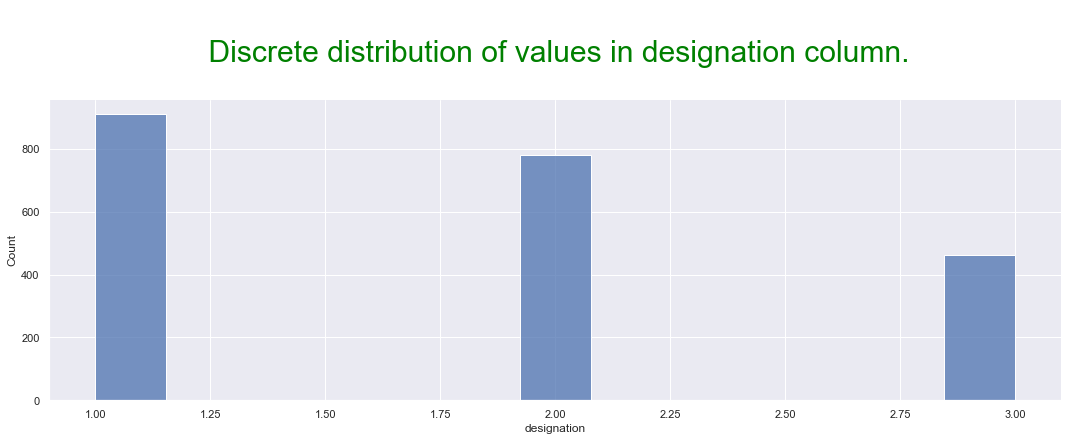

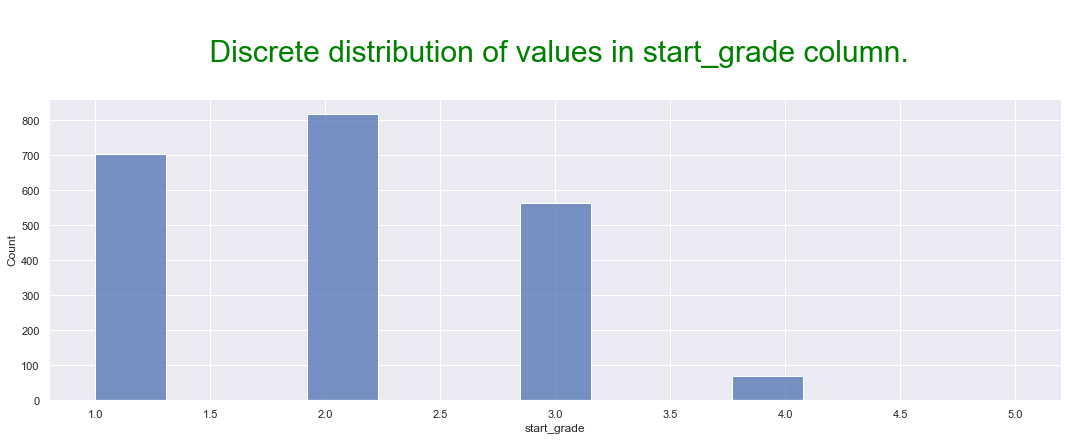

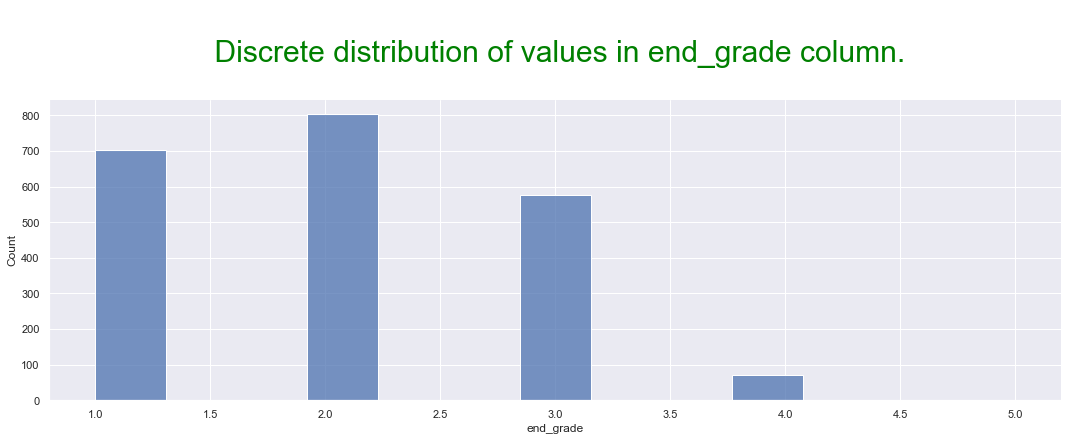

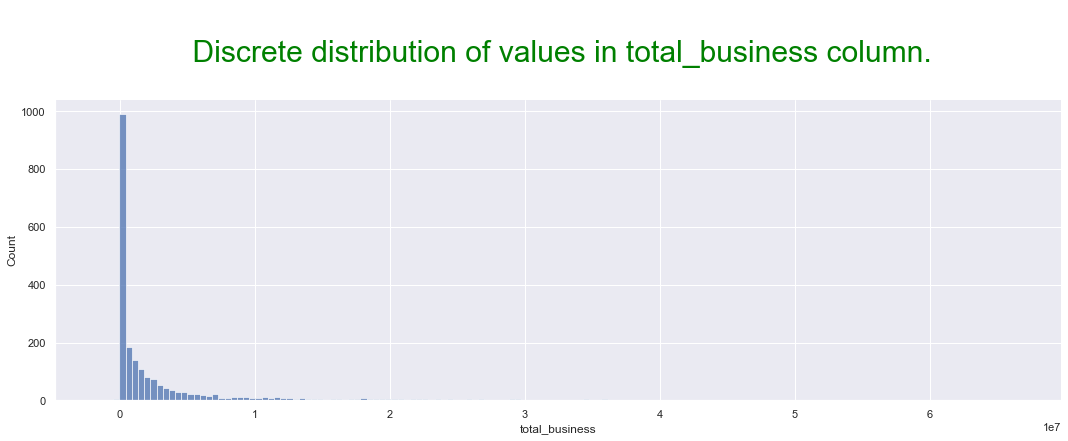

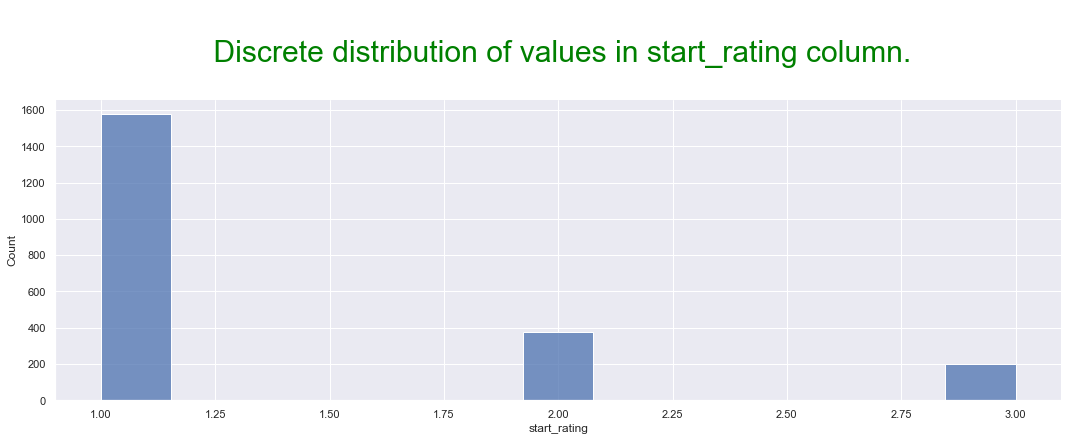

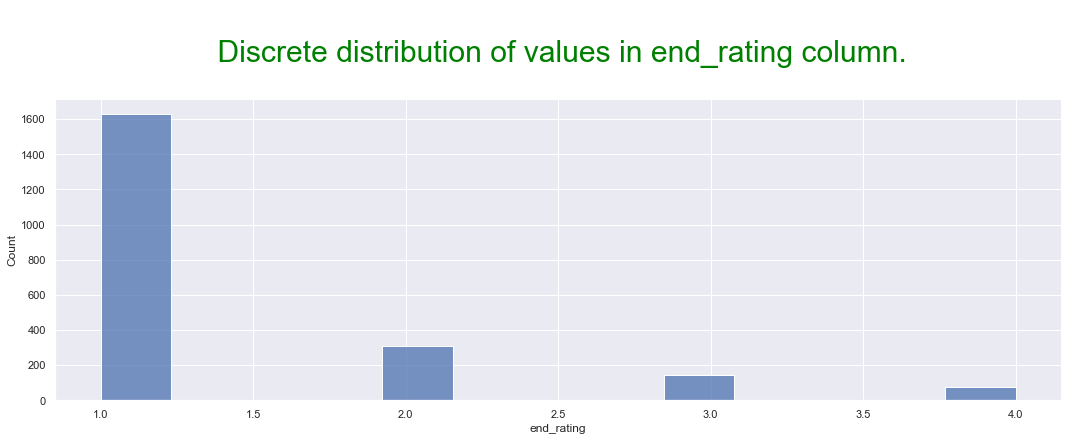

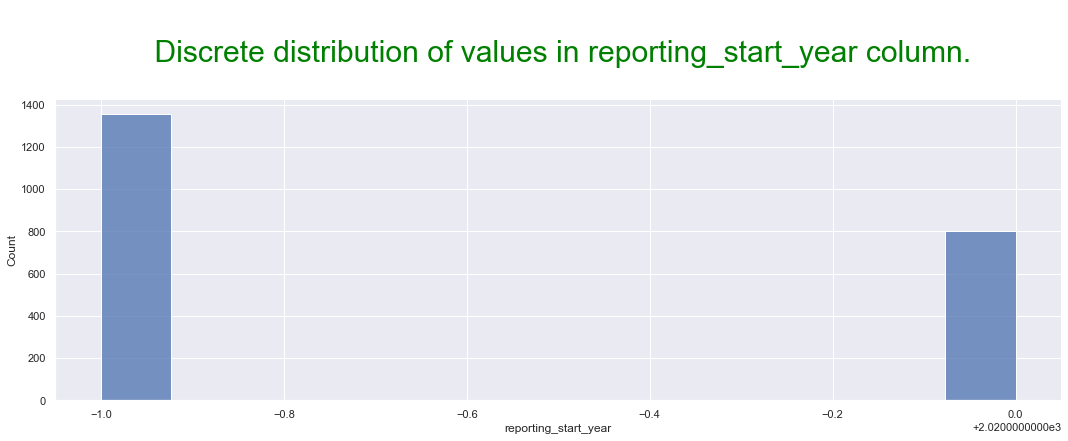

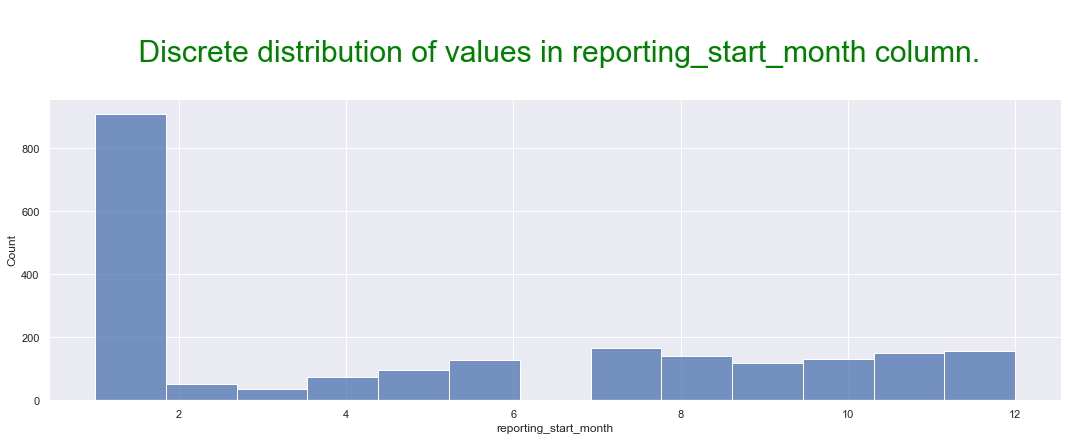

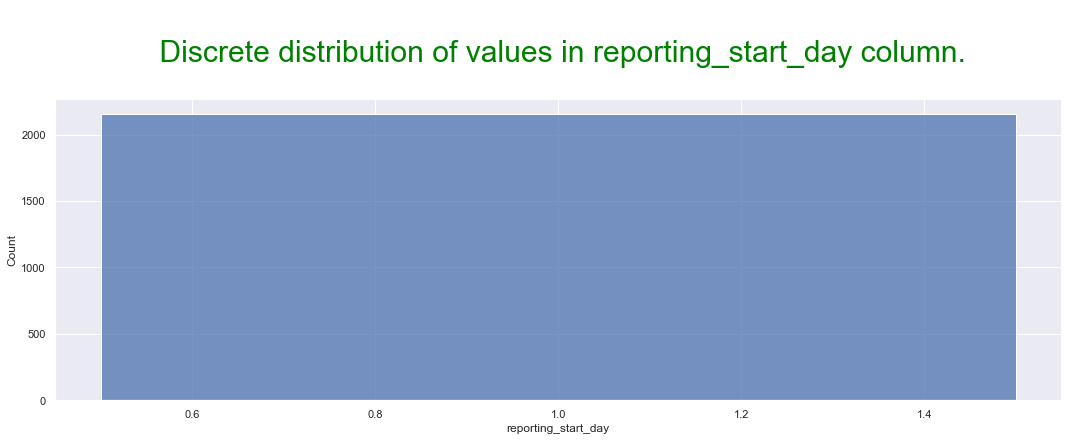

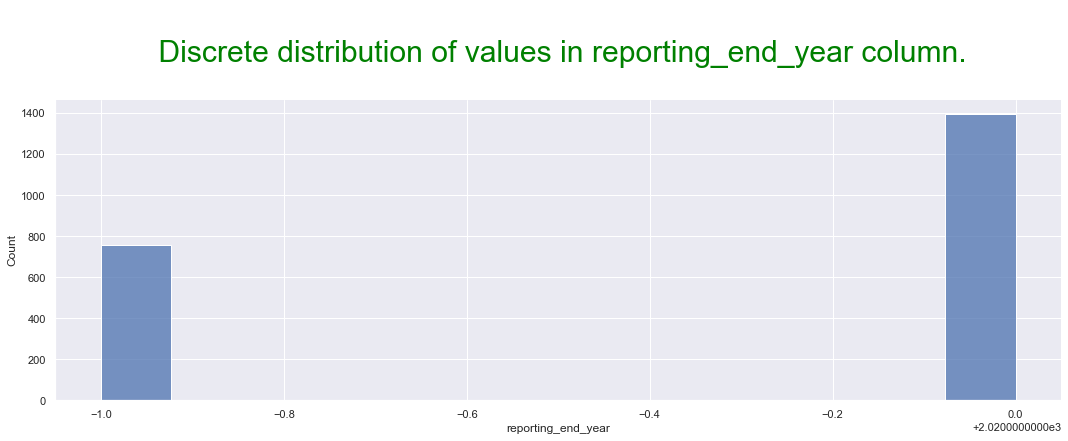

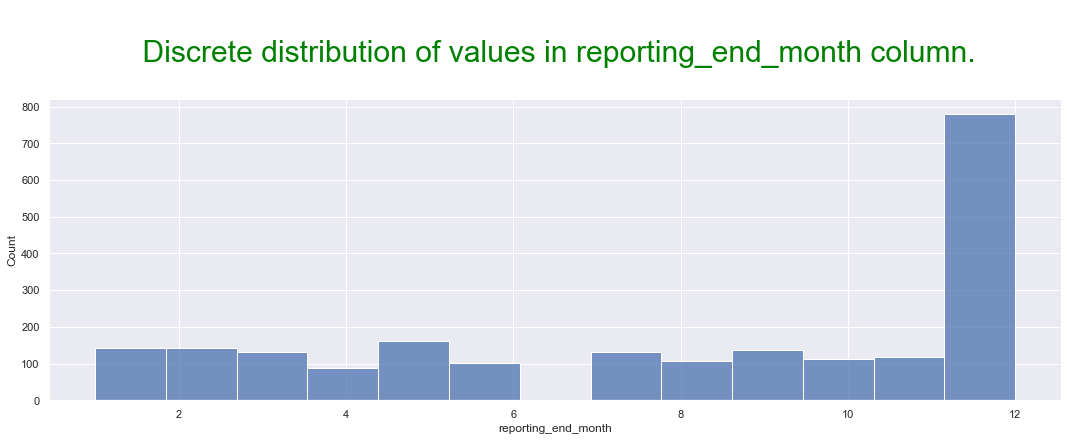

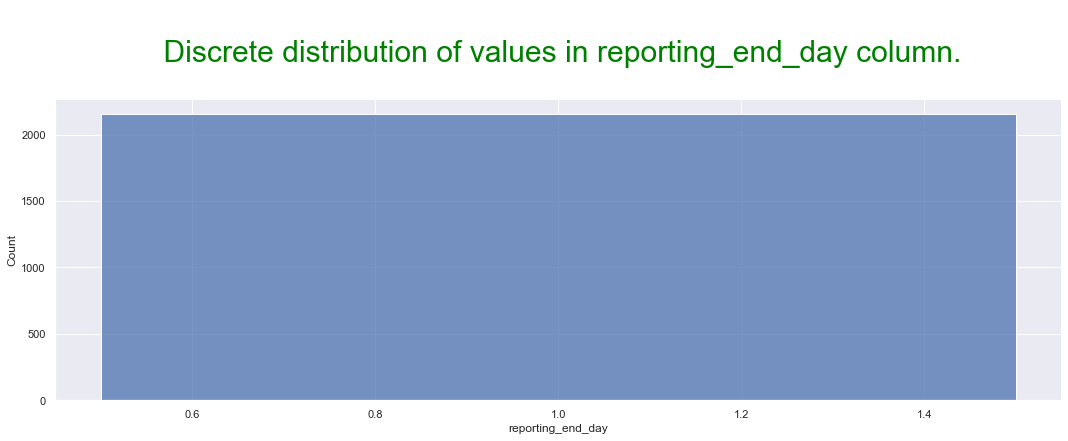

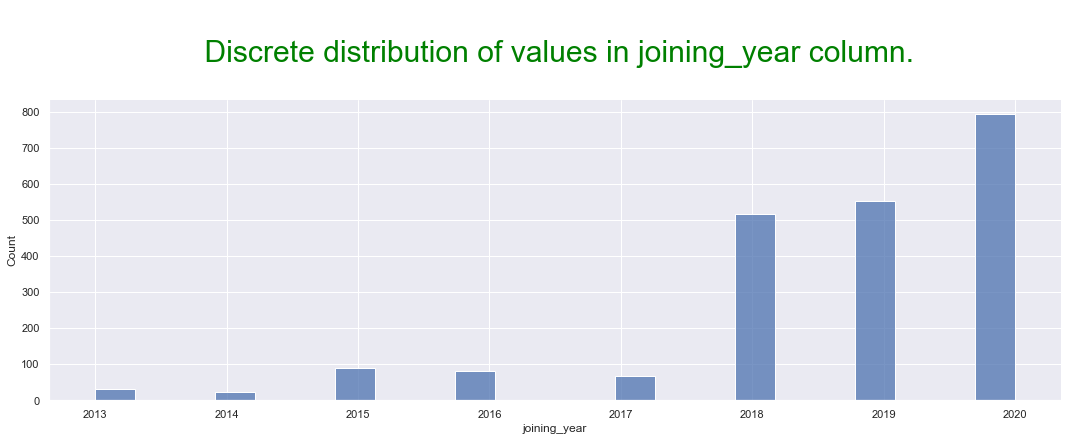

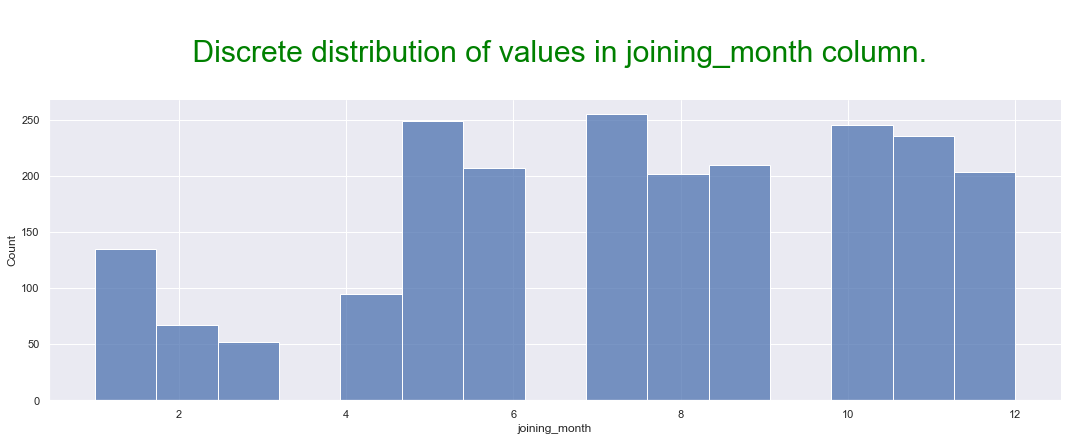

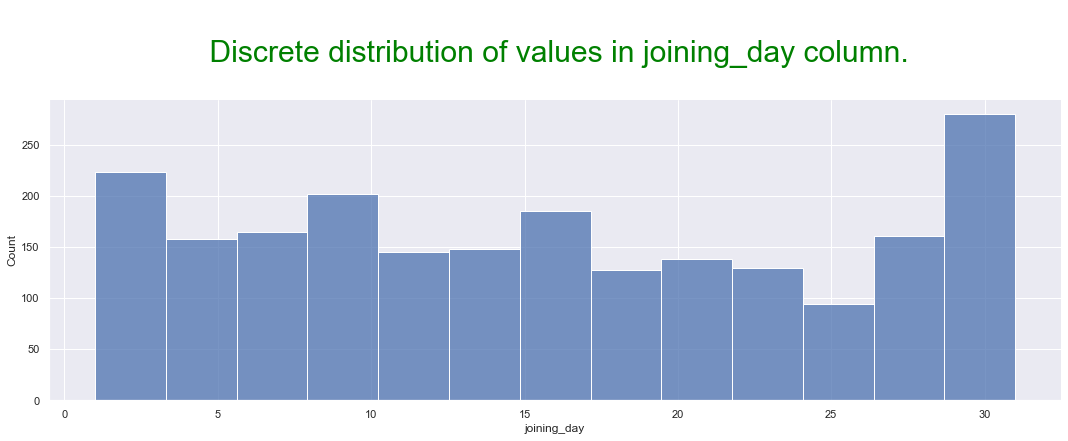

In [23]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=False, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **7. Univariate Analysis (Continuous Data).**

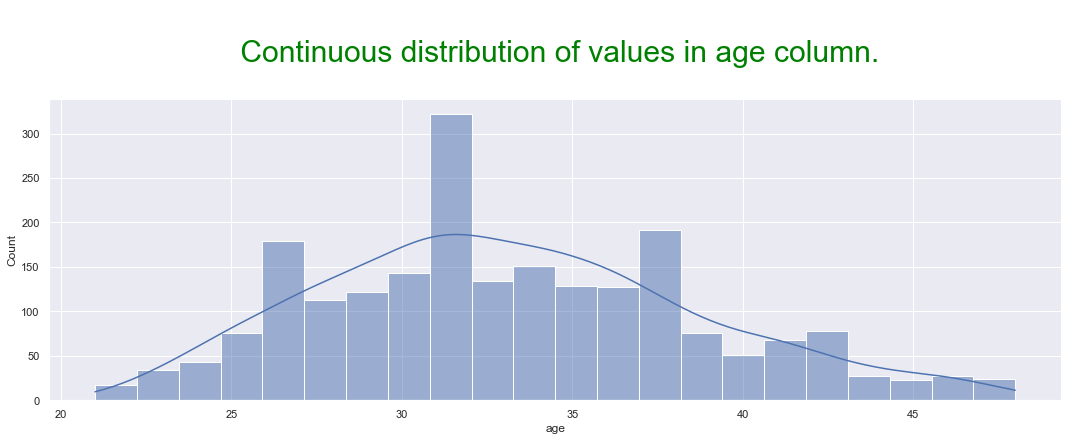

In [24]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **8. Bivariate Analysis.**

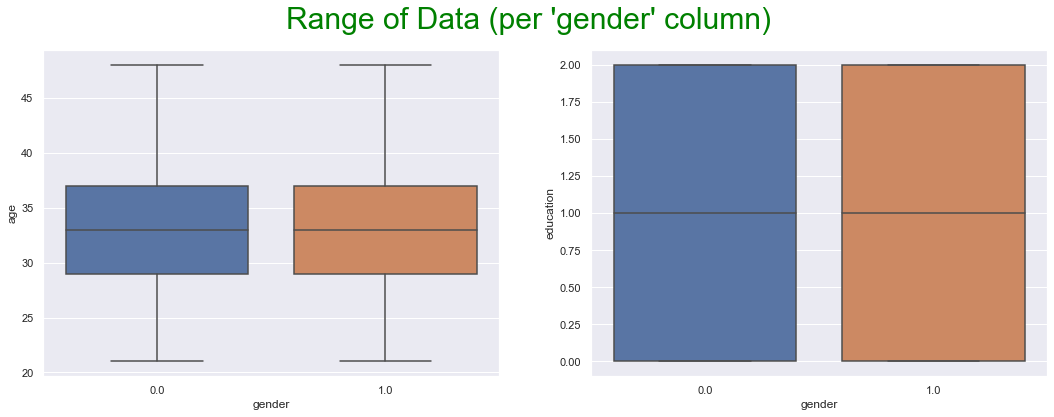

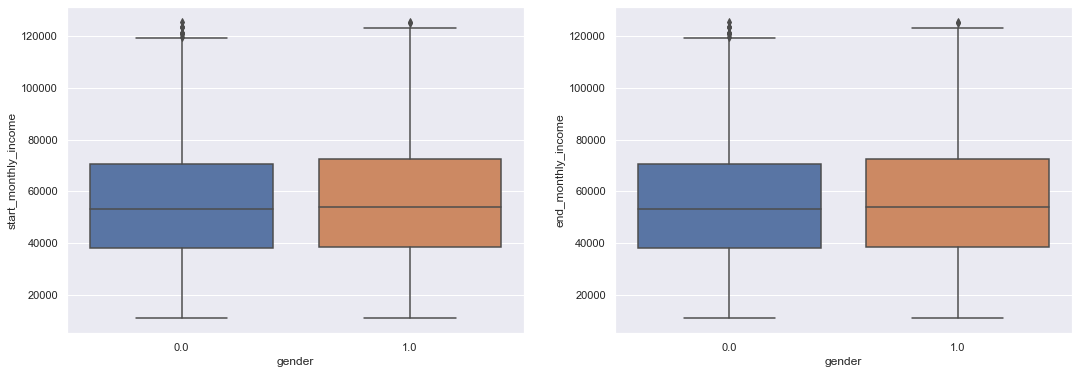

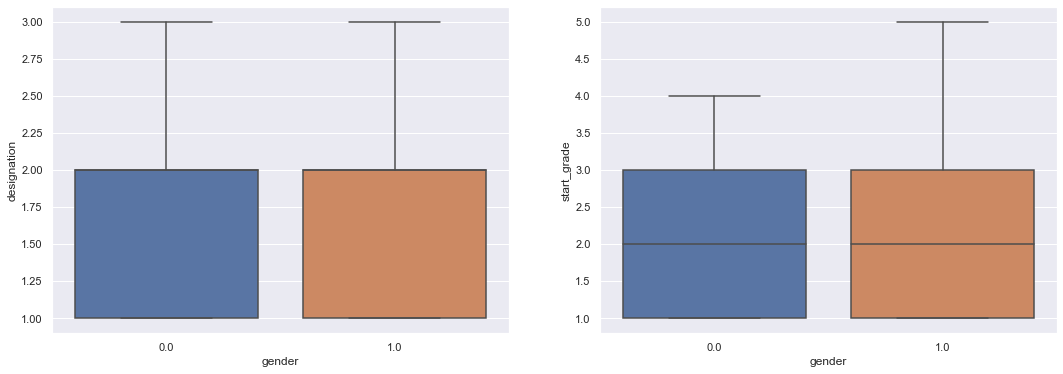

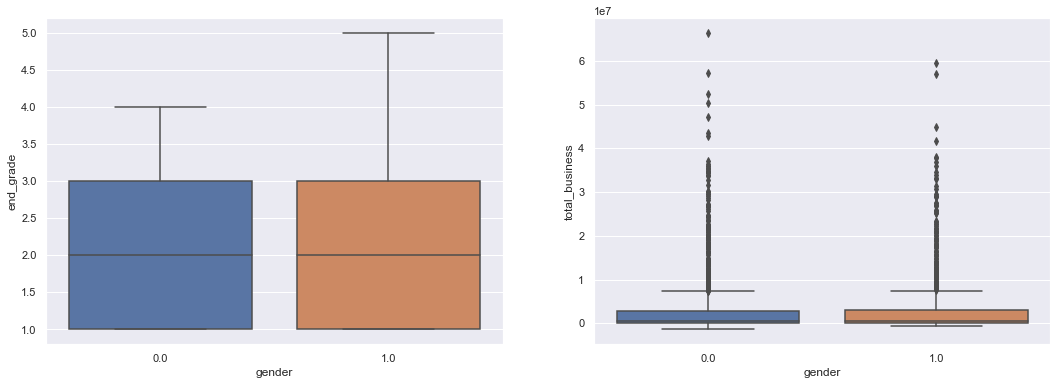

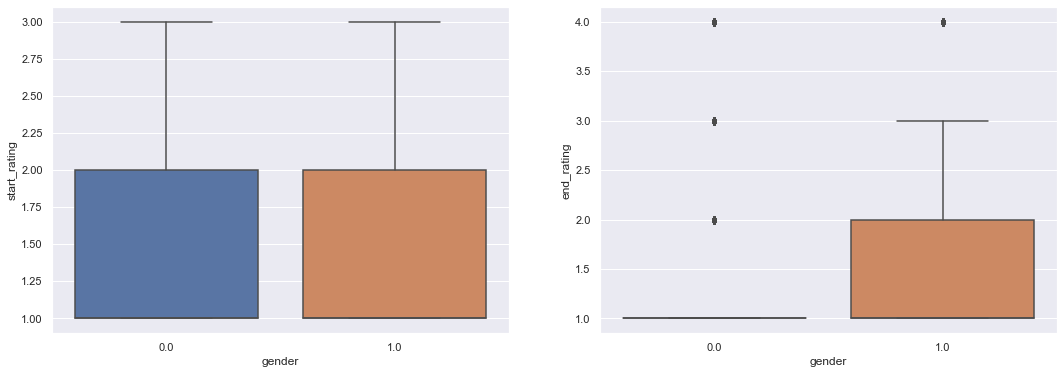

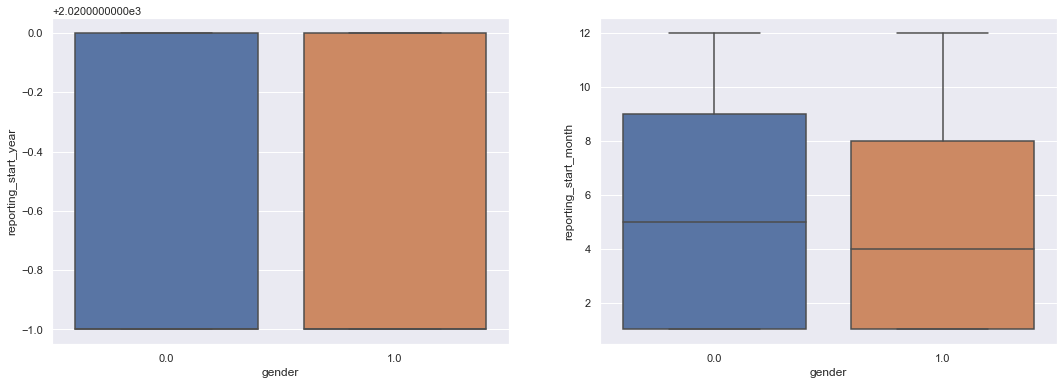

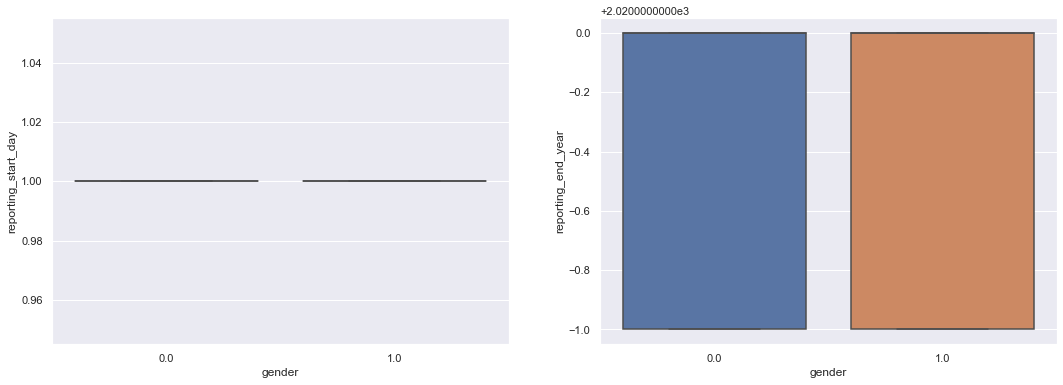

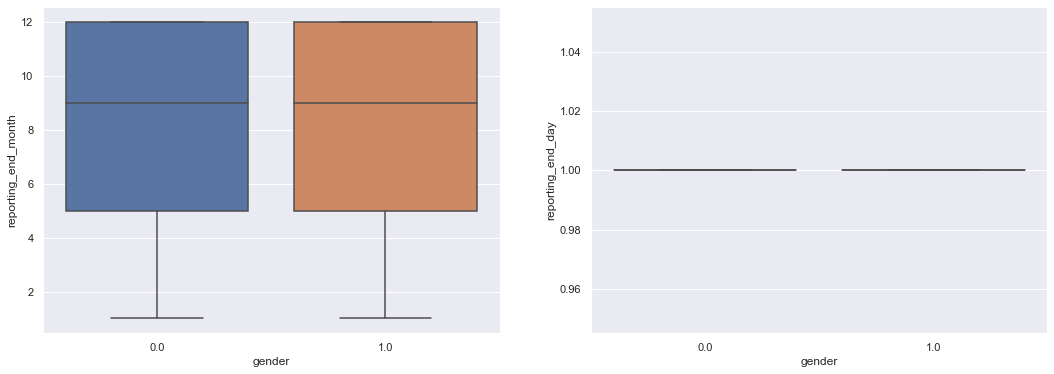

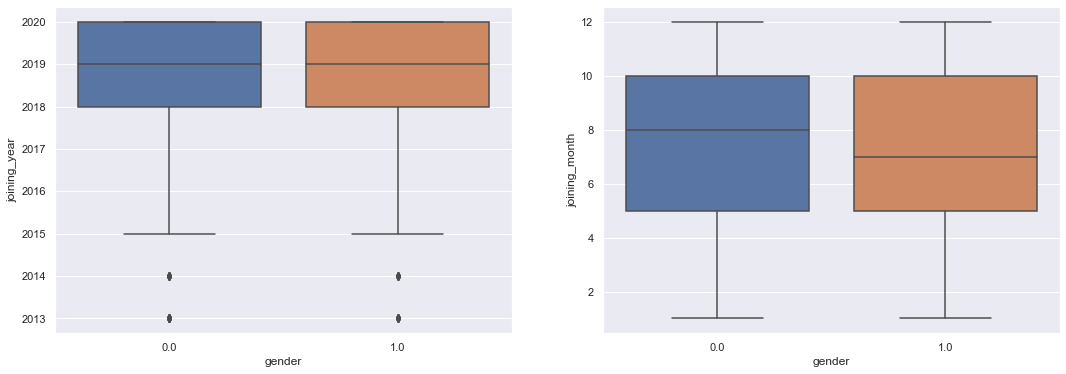

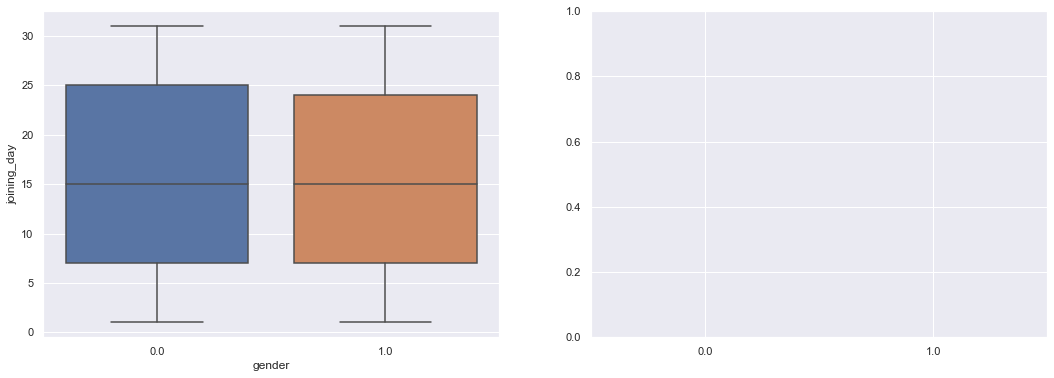

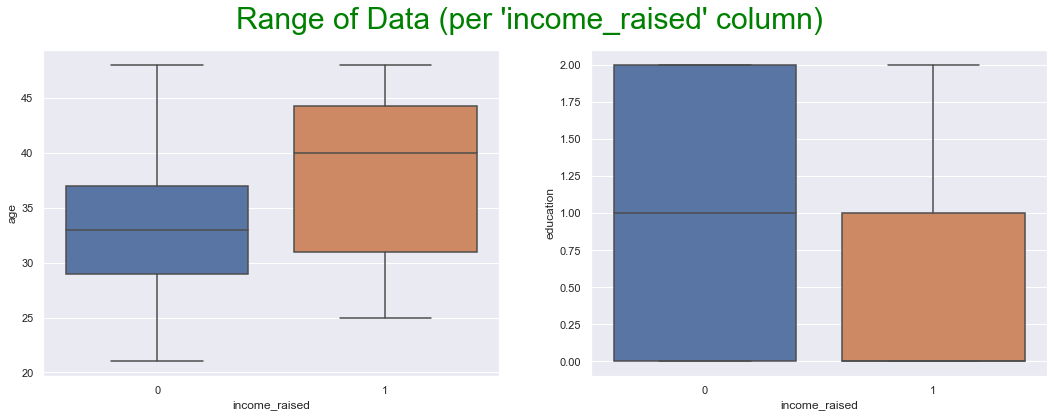

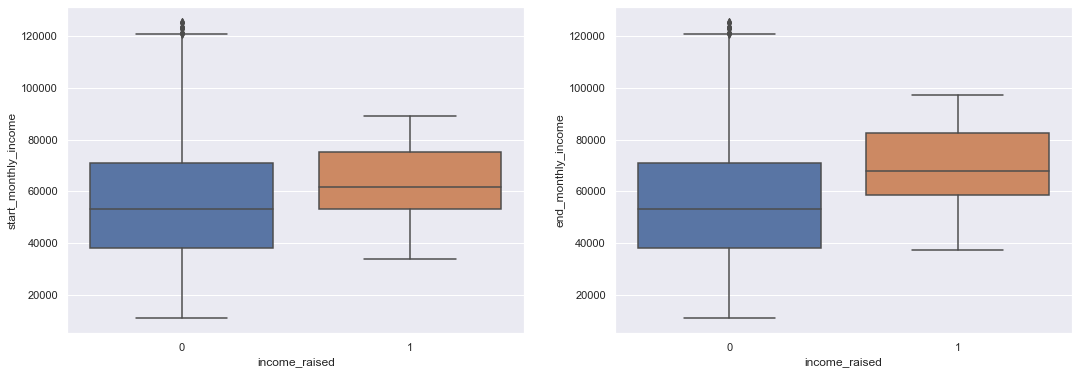

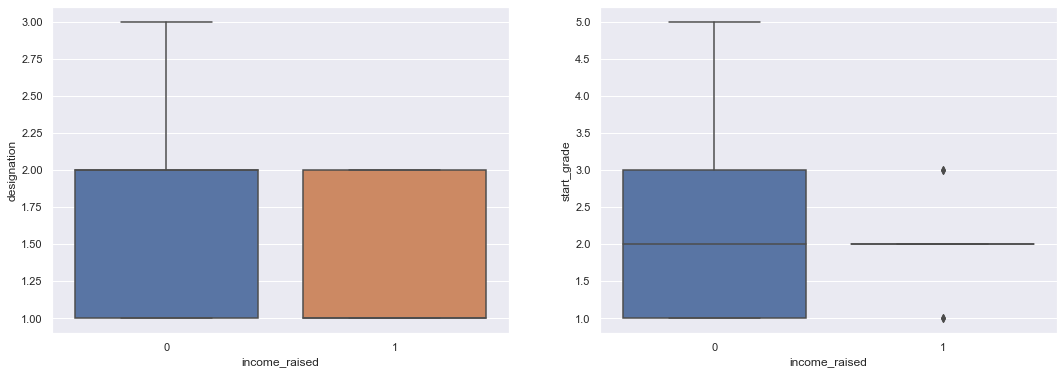

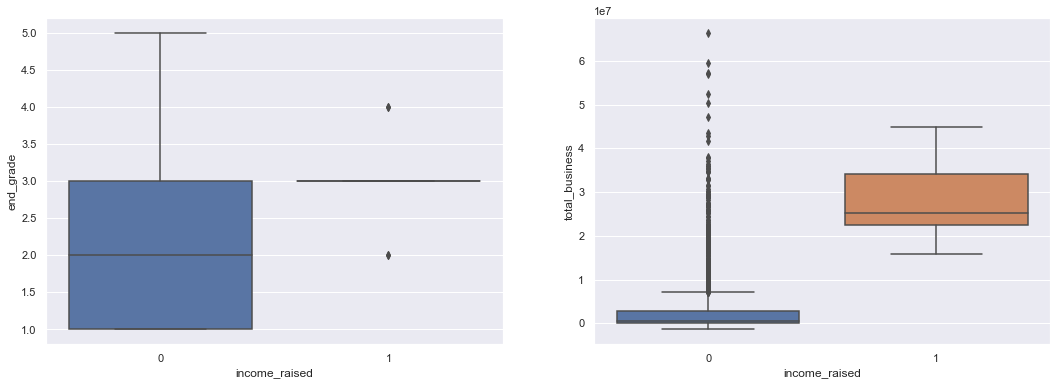

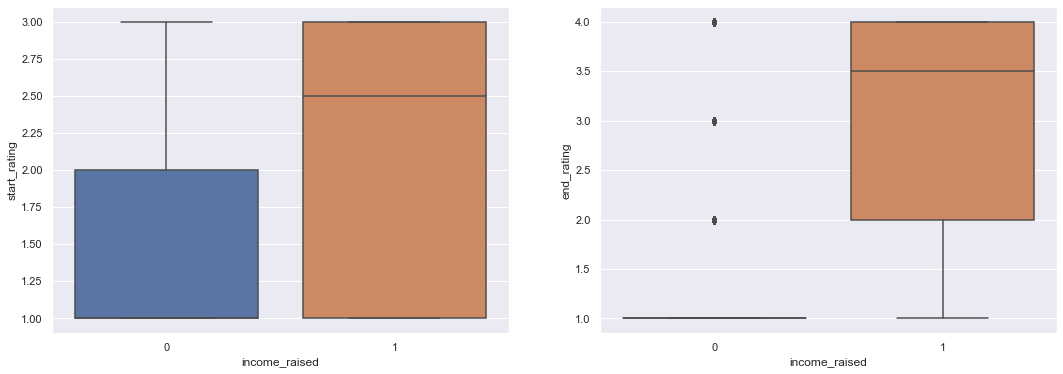

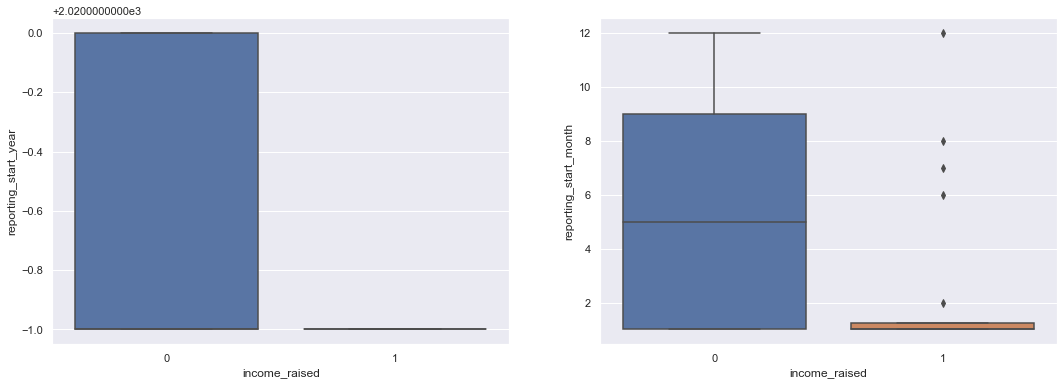

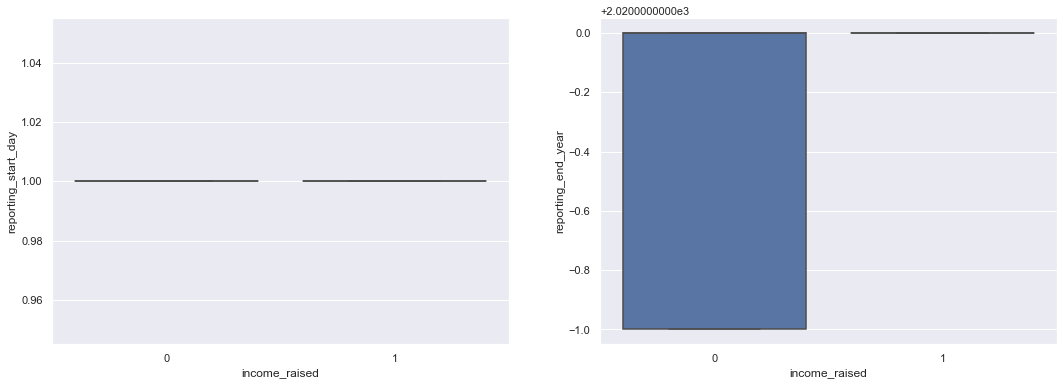

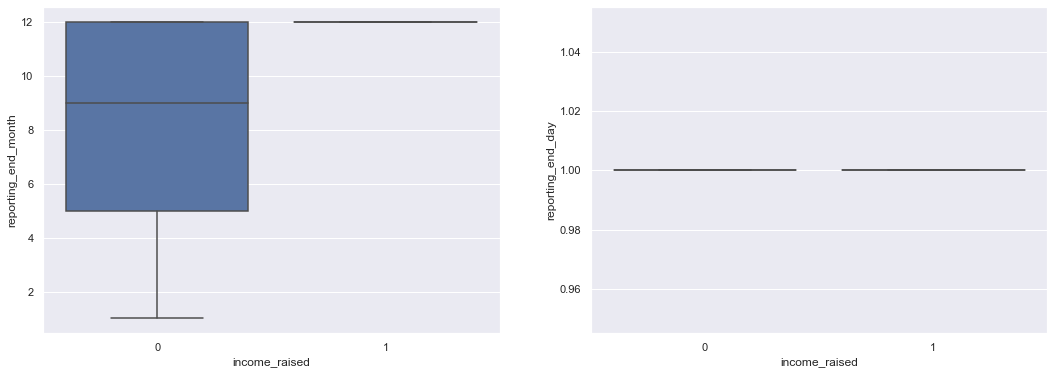

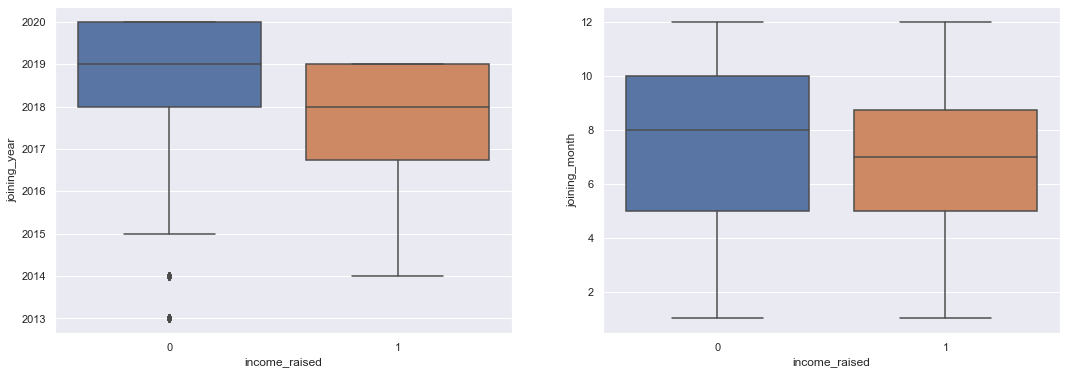

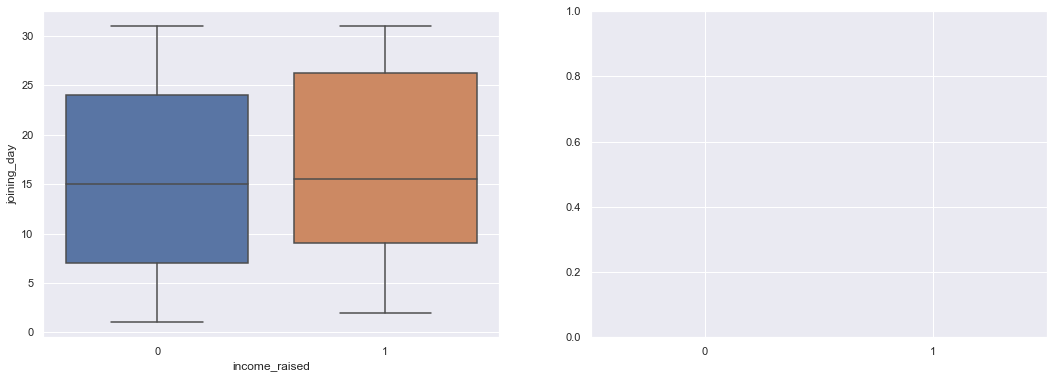

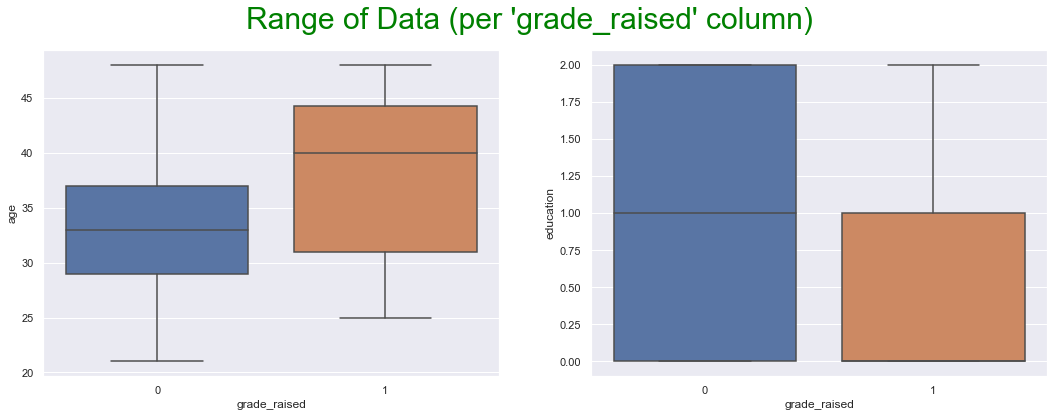

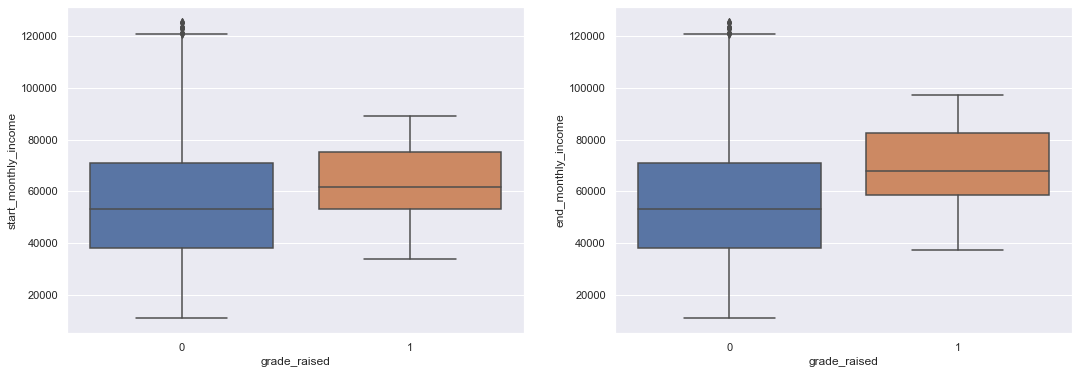

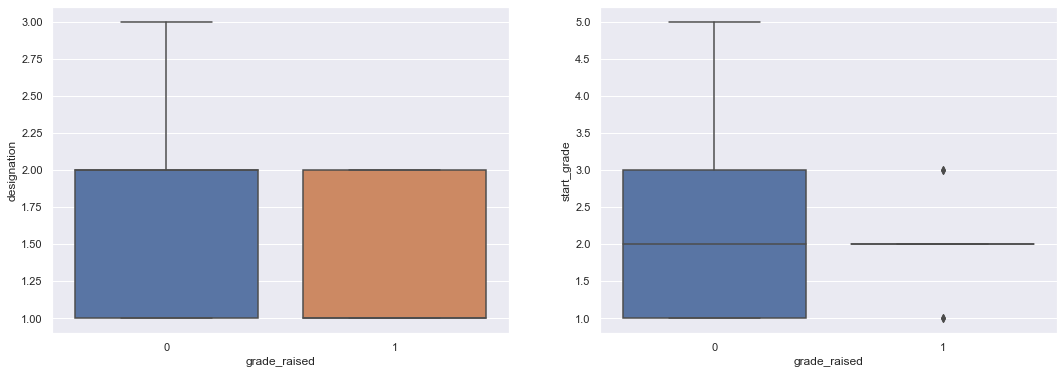

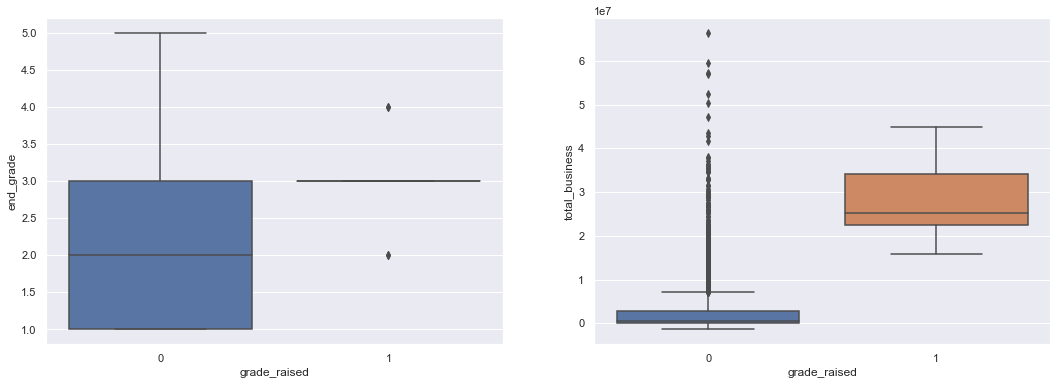

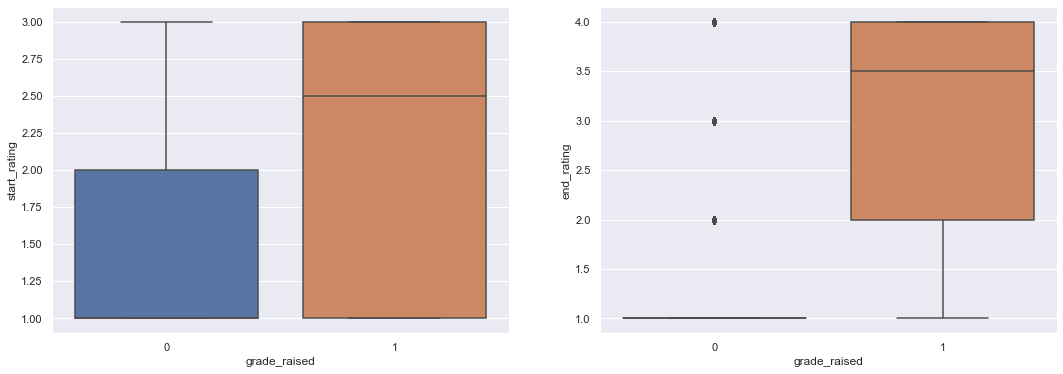

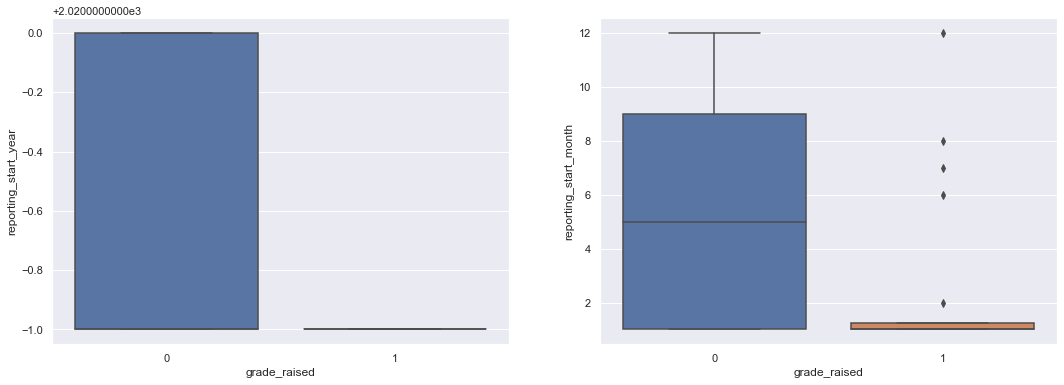

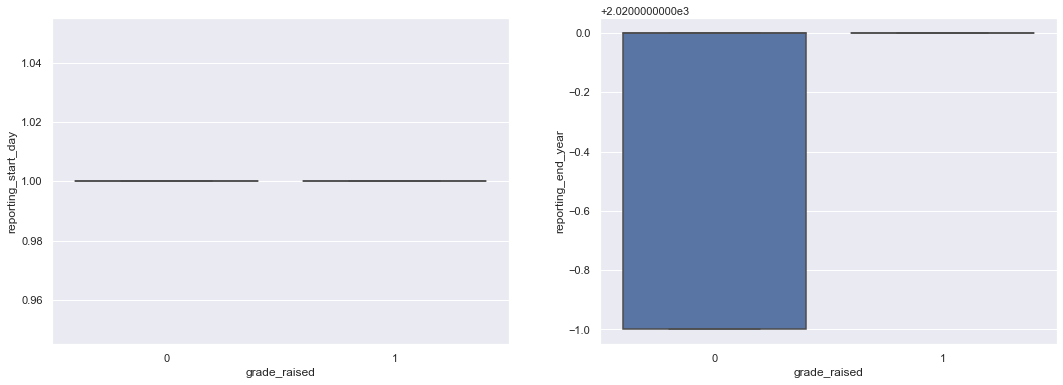

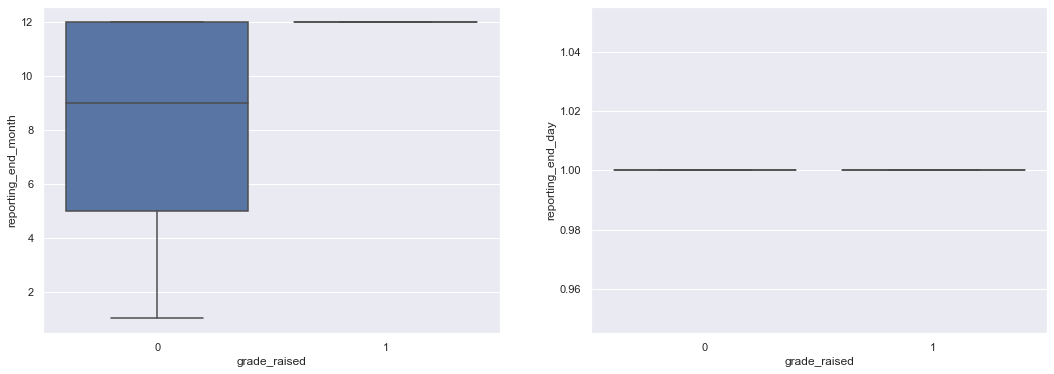

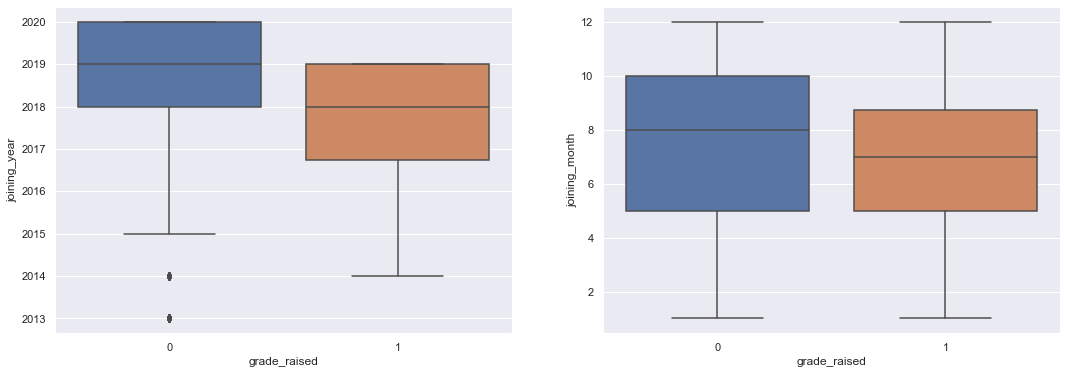

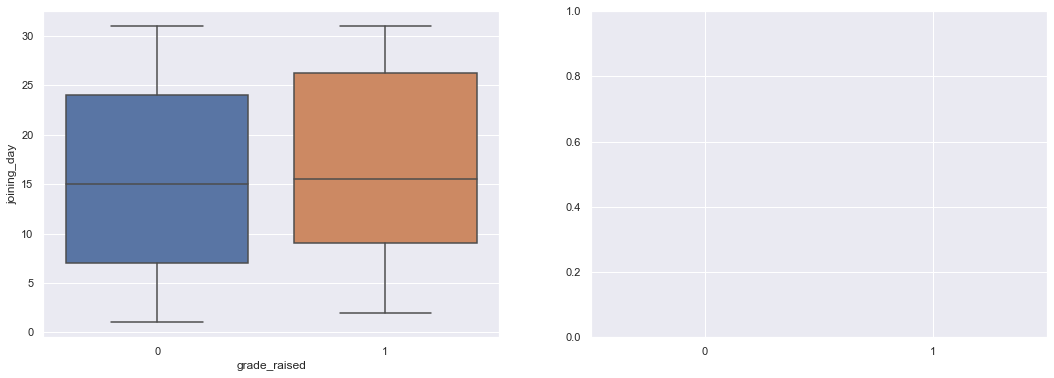

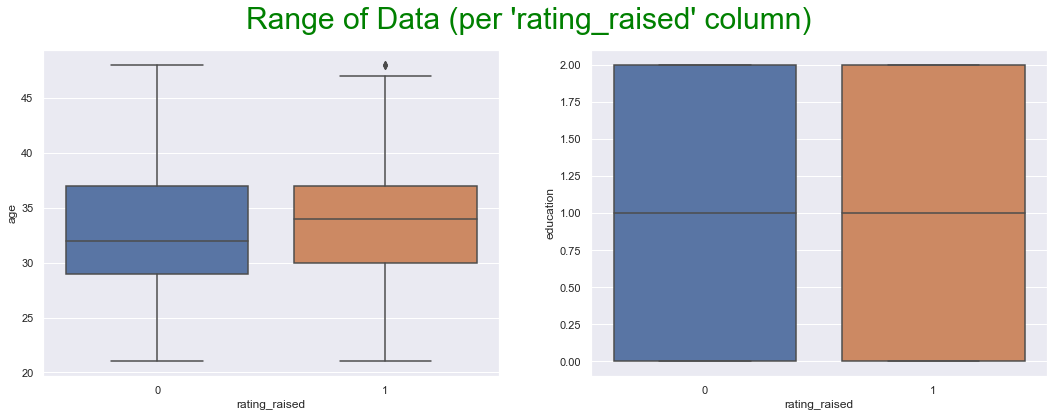

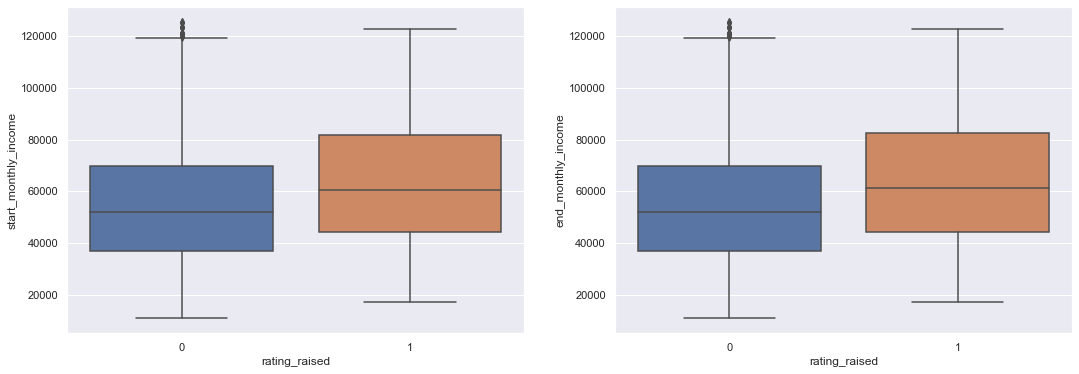

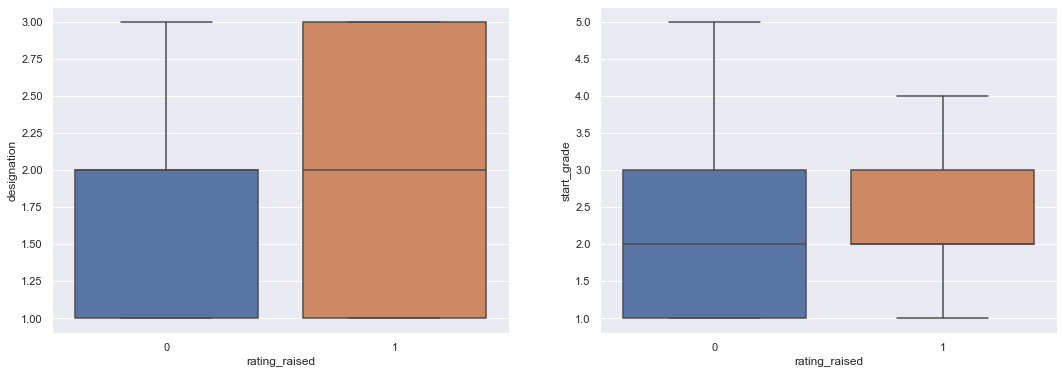

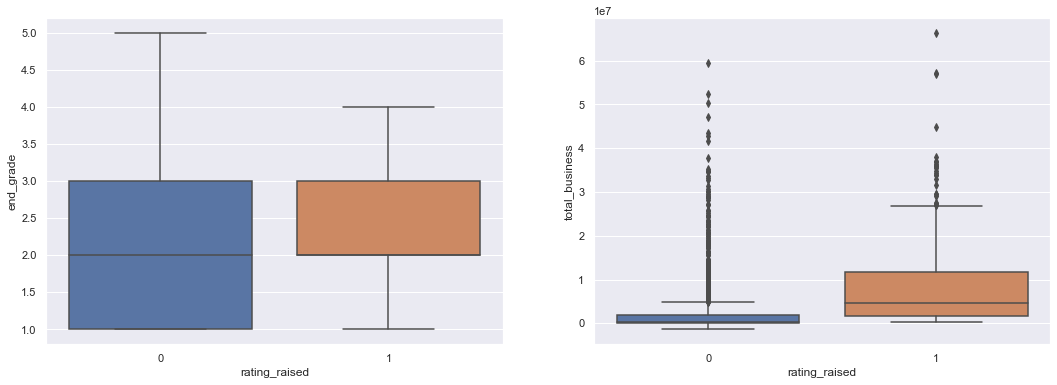

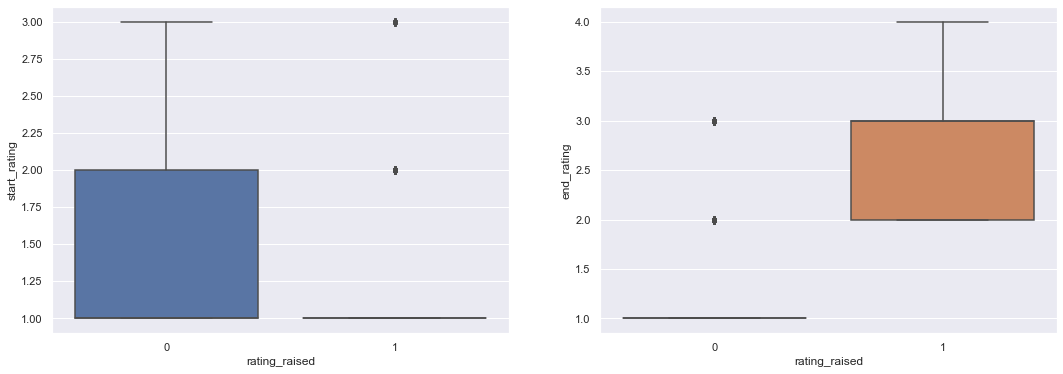

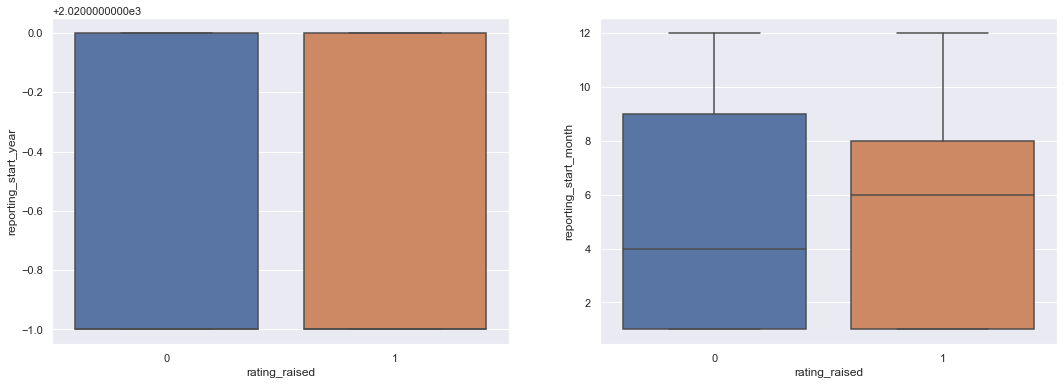

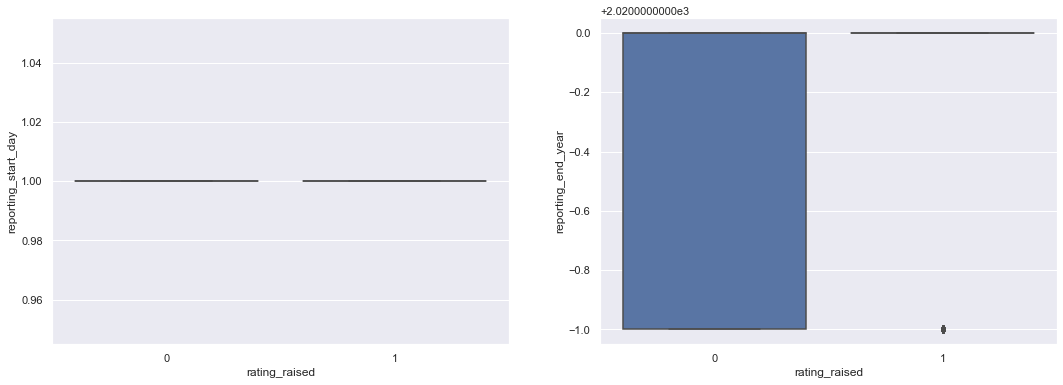

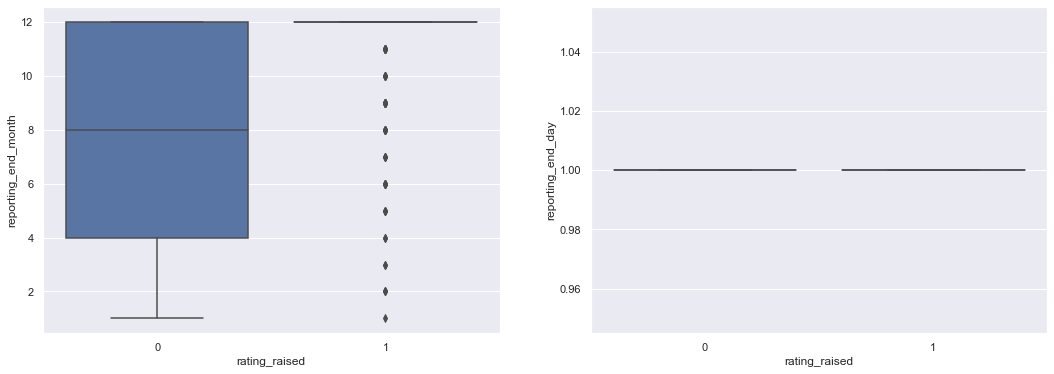

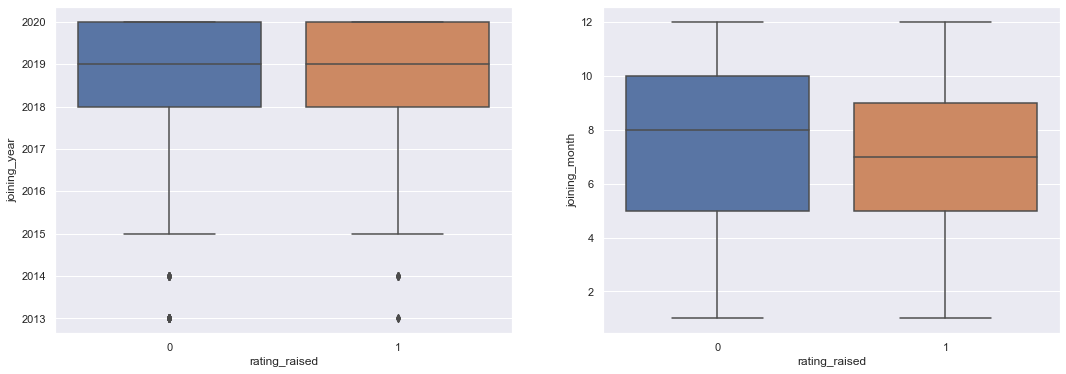

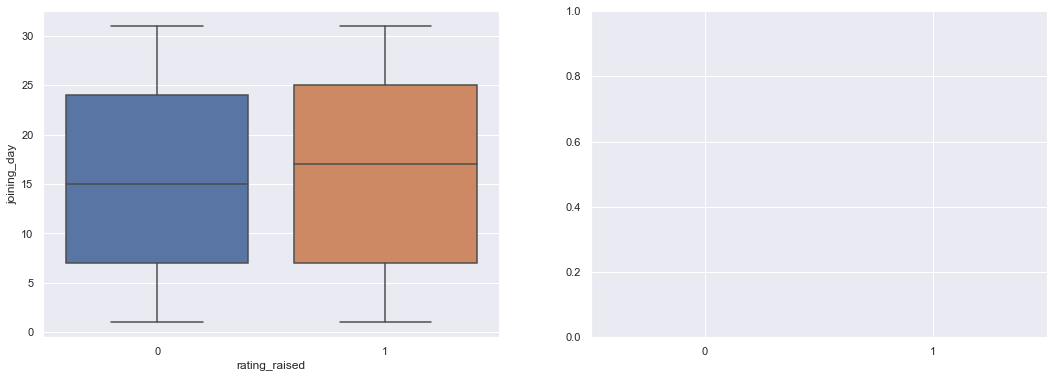

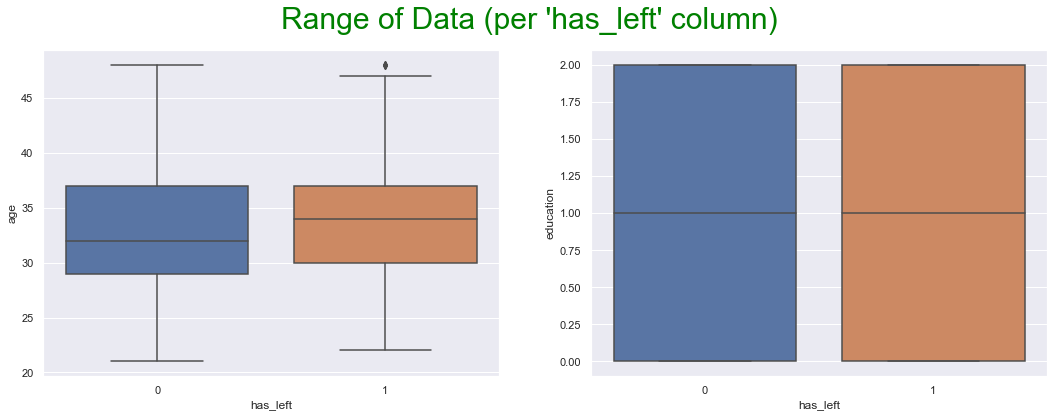

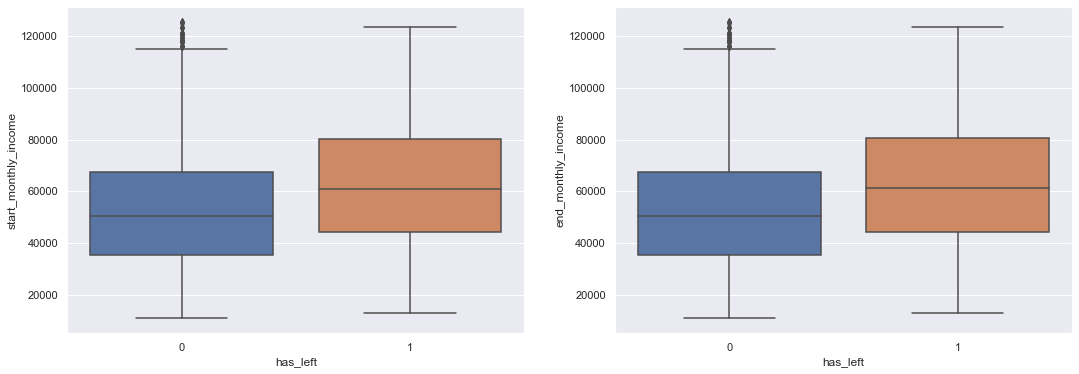

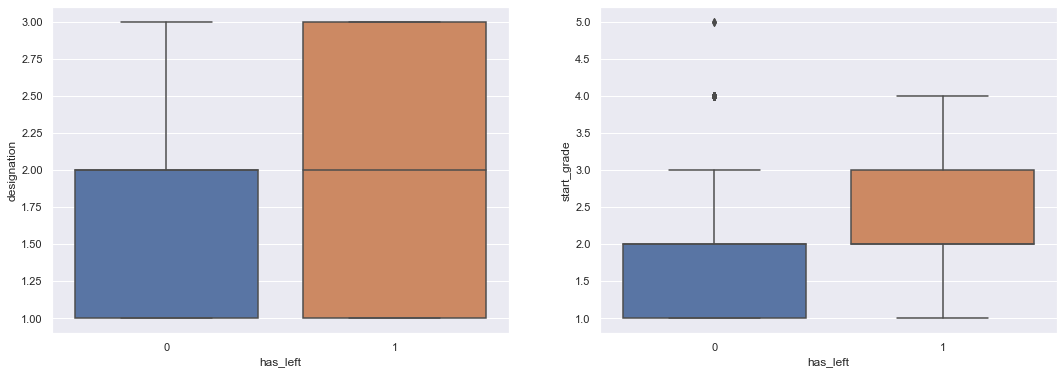

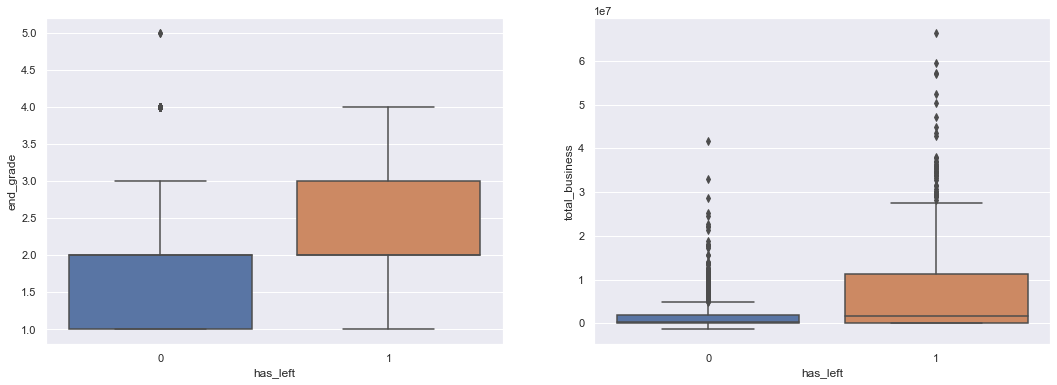

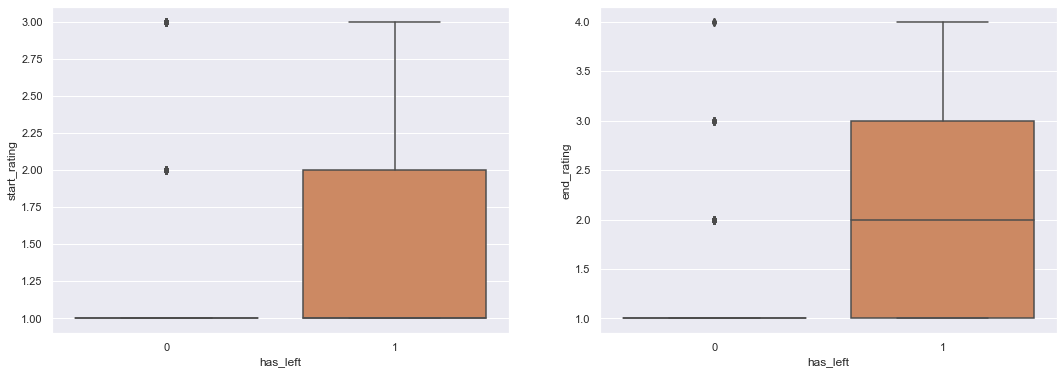

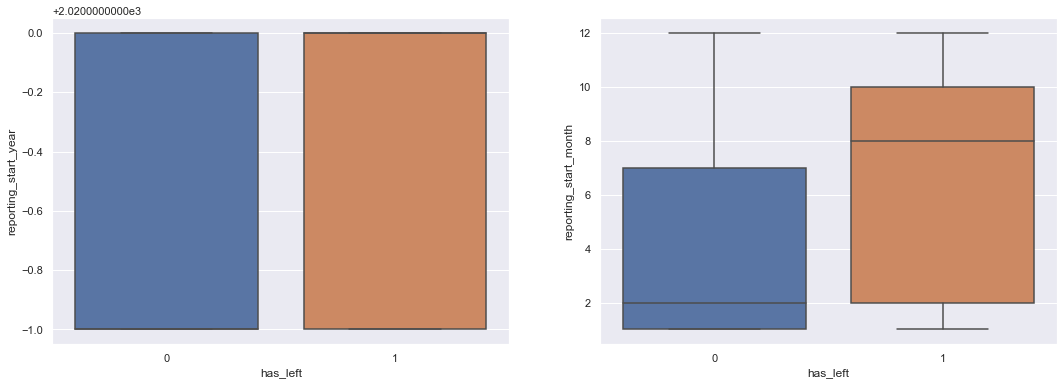

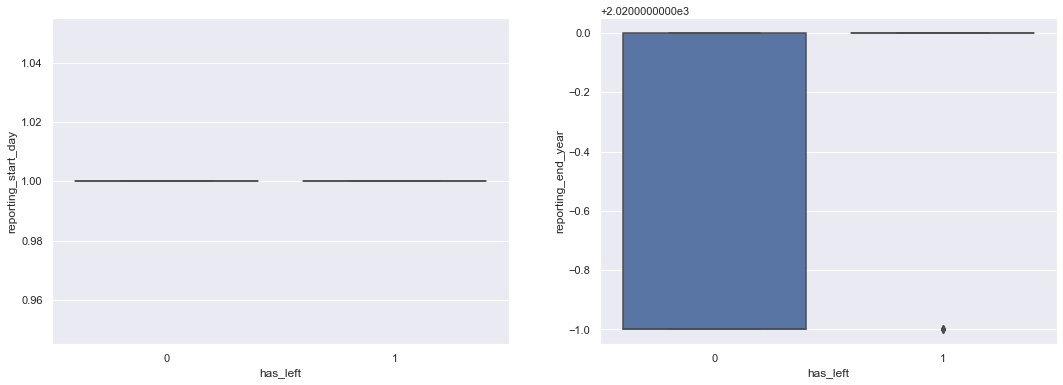

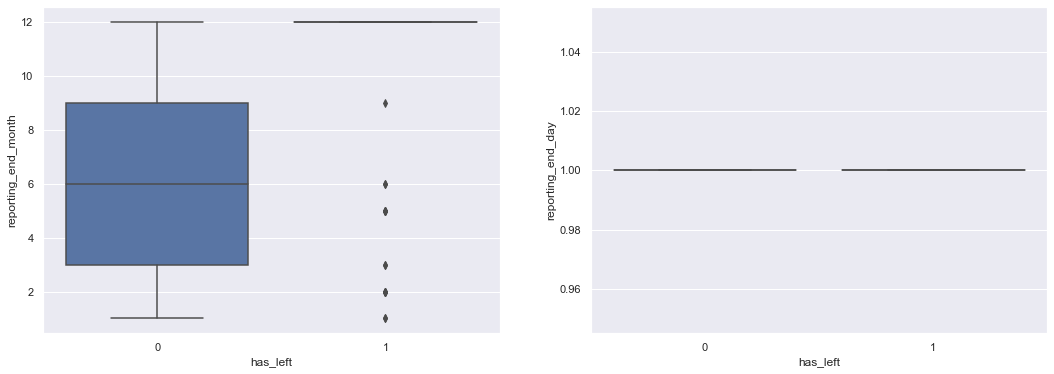

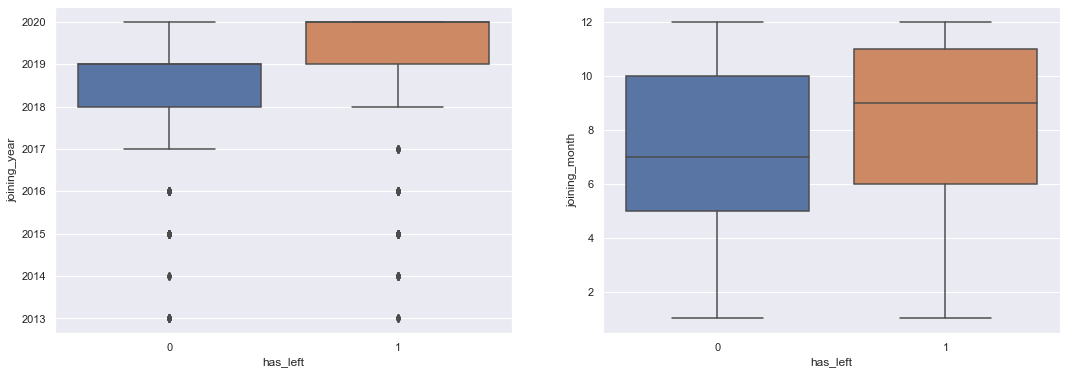

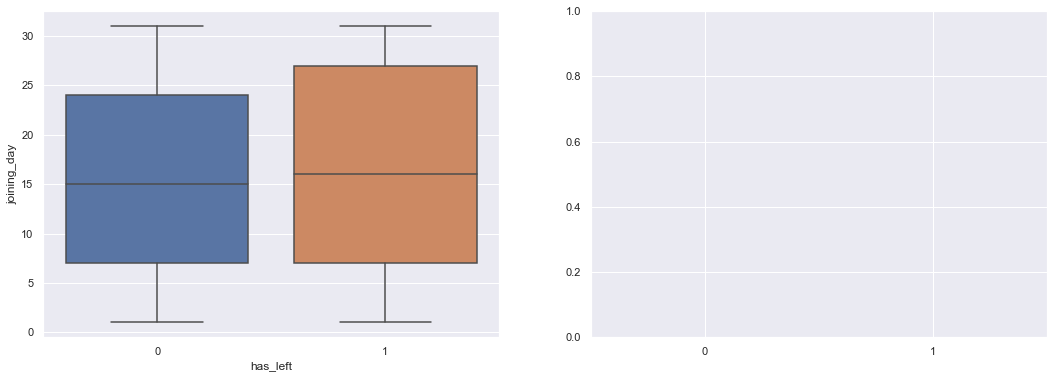

In [25]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **9. Analysis of Correlation Between Data.**

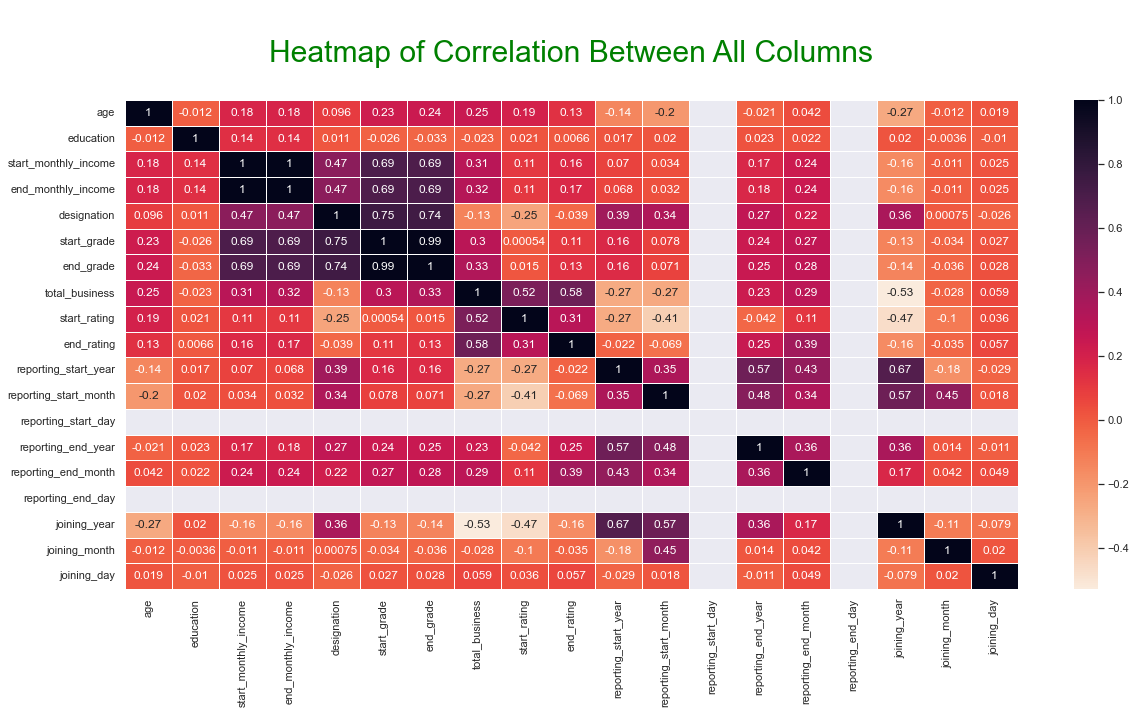

In [26]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
### 1. Since start_grade is highly correlated with end_grade, removing start_grade column.
### 2. Since start_monthly_income is highly correlated with end_monthly_income, removing start_monthly_income column.
### 3. Since reporting_start_day and reporting_end_day have only one values, removing both the fields..

In [27]:
df = df.drop(['reporting_start_day', 'reporting_end_day', 'start_monthly_income', 'start_grade'], axis=1)

***
***
## **10. Treat Target Variable Imbalance.**

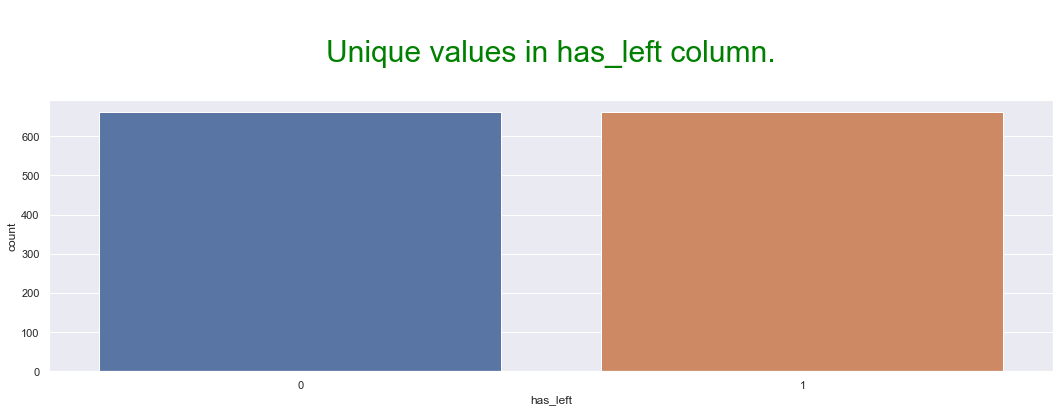

In [28]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(df.drop('has_left', axis=1), df['has_left'])
df = pd.concat([X_over, y_over], axis=1)
fig, axes = plt.subplots(figsize=(18,5))
sns.countplot(data=df, x='has_left')
plt.title(f"\nUnique values in has_left column.\n", fontsize=30, color="green")
plt.show()

***
***
## **11. Train-Test Split.**

In [29]:
for category in get_columns_by_types(df, categorical_types):
    df[category] = df[category].astype(int)
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['has_left'], axis=1), df['has_left'], random_state=0, test_size = .2)

***
***
## **12. Feature Encoding and Feature Scaling on Train Data.**

In [30]:
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)

In [31]:
X_train_columns=X_train.columns
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

In [32]:
X_train.head()

,age,gender,city,education,end_monthly_income,designation,end_grade,total_business,start_rating,end_rating,income_raised,grade_raised,rating_raised,reporting_start_year,reporting_start_month,reporting_end_year,reporting_end_month,joining_year,joining_month,joining_day
0,1.592333,1.202813,-0.111353,-1.228821,-0.437511,-1.057442,-1.249474,-0.449921,-0.573386,-0.614855,-0.10716,-0.10716,-0.522967,-0.887972,0.102555,-1.694637,0.242817,0.189794,-0.582313,0.753000
1,-1.128482,-0.831384,-0.539355,1.228821,0.162030,-1.057442,-1.249474,-0.530735,-0.573386,-0.614855,-0.10716,-0.10716,-0.522967,1.126162,1.538330,0.590097,0.773101,0.781571,1.053798,1.274915
2,-0.402931,-0.831384,0.848779,1.228821,1.808286,1.479939,1.010054,-0.490712,-0.573386,-0.614855,-0.10716,-0.10716,-0.522967,1.126162,0.581147,0.590097,0.773101,0.781571,-0.255091,1.588064
3,-1.128482,-0.831384,1.026848,-1.228821,1.861597,1.479939,1.010054,-0.530735,-0.573386,-0.614855,-0.10716,-0.10716,-0.522967,1.126162,1.299034,0.590097,0.773101,0.781571,1.053798,-0.082065
4,-0.221544,-0.831384,1.345889,0.000000,-0.843510,-1.057442,-1.249474,-0.182536,-0.573386,0.564640,-0.10716,-0.10716,1.912168,-0.887972,1.538330,0.590097,0.773101,0.189794,1.053798,1.274915


In [33]:
X_train.shape, y_train.shape

((1057, 20), (1057,))

***
***
## **13. Feature Encoding and Feature Scaling on Test Data.**

In [34]:
X_test = target_encoder.transform(X_test)

In [35]:
X_test_columns=X_test.columns
X_test_std=std.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)

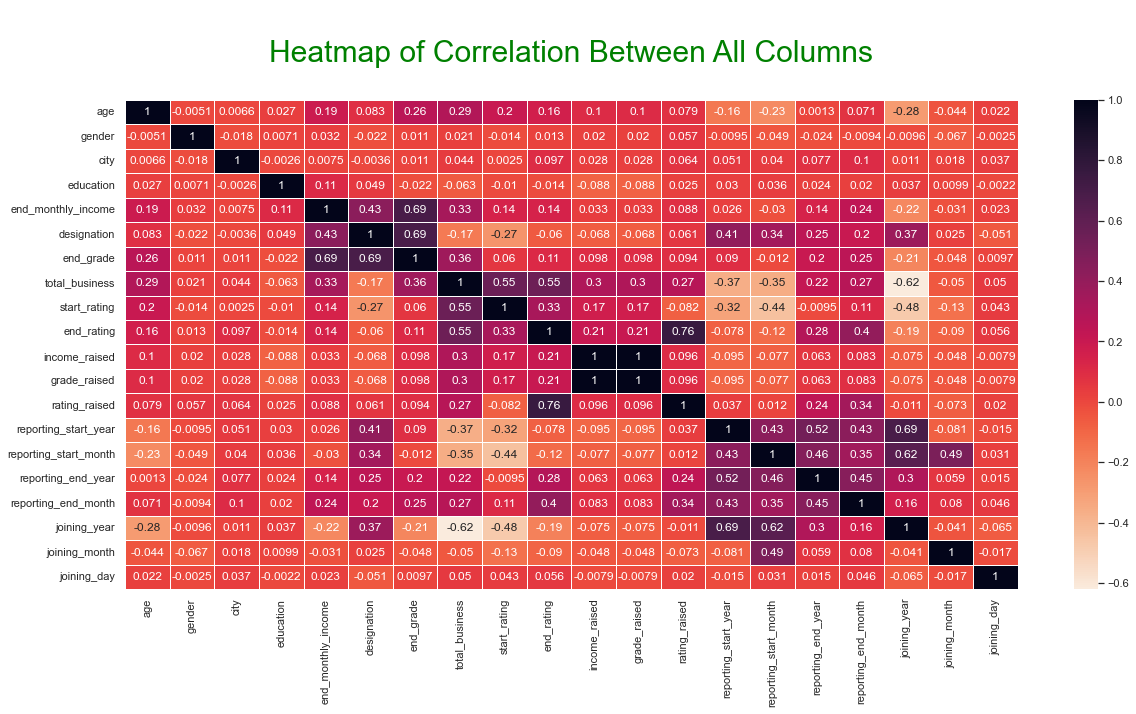

In [36]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(X_train.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **14. Bagging - Random Forest.**

***
### 1. Hyperparameter Tuning.

In [37]:
params = {
          'n_estimators' : [5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
          'max_depth' : [1, 2, 3, 4, 5,10, 15, 20, 40],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [2, 4, 6, 8, 10, 15, 20]
         }

In [38]:
tuning_function = GridSearchCV(estimator = RandomForestClassifier(), 
                               param_grid = params,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

In [39]:
tuning_function.fit(X_train, y_train)

parameters = tuning_function.best_params_
score = tuning_function.best_score_
print(parameters)
print(score)  

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.9659412825135204


***
### 2. Threefold Cross Validation.

In [85]:
tree_clf = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini', max_depth=10, max_features=4, n_estimators=50)
kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
print(f"K-Fold Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")

K-Fold Accuracy Mean: Train: 99.67414883934647 Validation: 96.21653189577717
K-Fold Accuracy Std: Train: 0.1519339941769368 Validation: 2.5018370768623868


***
### 3. Training the model on best hyperparameters.

In [86]:
tree_clf = RandomForestClassifier(random_state=7, bootstrap=False, criterion='gini', max_depth=10, max_features=4, n_estimators=50)

In [87]:
tree_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=4,
                       n_estimators=50, random_state=7)

***
### 4. Model Accuracy and Classification Report on Test Data.

In [88]:
tree_clf.score(X_test, y_test)

0.9509433962264151

In [89]:
print(classification_report(y_test, tree_clf.predict(X_test), target_names=['Not left', 'Left']))

              precision    recall  f1-score   support

    Not left       0.96      0.94      0.95       127
        Left       0.94      0.96      0.95       138

    accuracy                           0.95       265
   macro avg       0.95      0.95      0.95       265
weighted avg       0.95      0.95      0.95       265



***
### 5. Precision Recall Curve.

In [90]:
y_score = tree_clf.predict_proba(X_test)[:, 1]

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

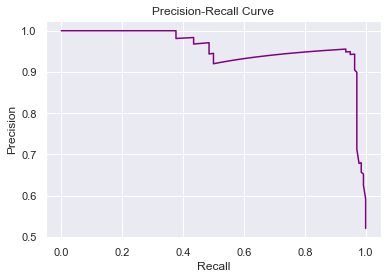

In [92]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [93]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.958923983499939


***
### 6. ROC AUC Curve.

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

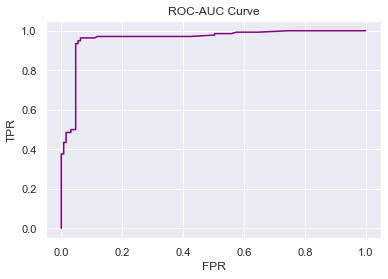

In [95]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [96]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9590322948761839


***
### 7. Accuracy Threshold Curve.

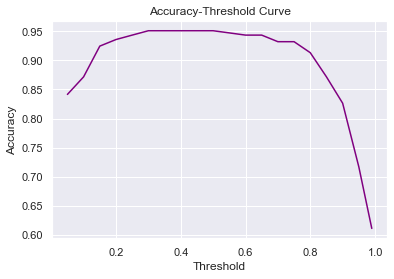

In [97]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [98]:
np.max(scores), np.argmax(scores)

(0.9509, 5)

In [99]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.3


***
### 8. F1-Score Threshold Curve.

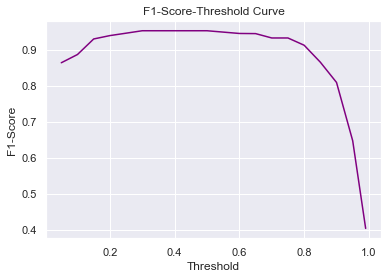

In [100]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [101]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9590322948761839


In [102]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.3


***
### 9. Feature Importance.

In [103]:
importances = tree_clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

reporting_end_month      0.438205
reporting_end_year       0.099916
total_business           0.070810
reporting_start_year     0.062971
end_rating               0.060771
reporting_start_month    0.049021
joining_year             0.046334
joining_month            0.038431
rating_raised            0.035208
end_monthly_income       0.023426
age                      0.017762
joining_day              0.014984
city                     0.013329
end_grade                0.007488
designation              0.006120
education                0.005400
start_rating             0.005158
gender                   0.003588
grade_raised             0.000665
income_raised            0.000414
dtype: float64

***
***
## **15. Boosting - GBDT.**

***
### 1. Hyperparameter Tuning.

In [59]:
params = {
          'n_estimators' : [5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
          'max_depth' : [1, 2, 3, 4, 5,10, 15, 20, 40],
          'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
         }

In [60]:
tuning_function = GridSearchCV(estimator = GradientBoostingClassifier(), 
                               param_grid = params,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

In [61]:
tuning_function.fit(X_train, y_train)

parameters = tuning_function.best_params_
score = tuning_function.best_score_
print(parameters)
print(score)  

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
0.963103056056314


***
### 2. Threefold Cross Validation.

In [104]:
gbdt_clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=4, random_state=0)
kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(gbdt_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

print(f"K-Fold Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
print(f"K-Fold Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")

K-Fold Accuracy Mean: Train: 97.27742358773162 Validation: 96.12129380053909
K-Fold Accuracy Std: Train: 0.2017258865856719 Validation: 1.8665929831942059


***
### 3. Training the model on best hyperparameters.

In [105]:
gbdt_clf = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, max_depth=3, random_state=0)

In [106]:
gbdt_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=30, random_state=0)

***
### 4. Model Accuracy and Classification Report on Test Data.

In [107]:
gbdt_clf.score(X_test, y_test)

0.9433962264150944

In [108]:
print(classification_report(y_test, gbdt_clf.predict(X_test), target_names=['Not left', 'Left']))

              precision    recall  f1-score   support

    Not left       0.94      0.94      0.94       127
        Left       0.94      0.95      0.95       138

    accuracy                           0.94       265
   macro avg       0.94      0.94      0.94       265
weighted avg       0.94      0.94      0.94       265



***
### 5. Precision Recall Curve.

In [109]:
y_score = gbdt_clf.predict_proba(X_test)[:, 1]

In [110]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

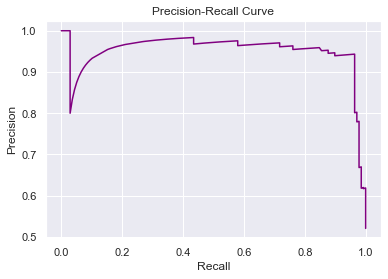

In [111]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [112]:
print(f"Area under precision Recall curve is {auc(recall, precision)}")

Area under precision Recall curve is 0.9505197025568833


***
### 6. ROC AUC Curve.

In [113]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

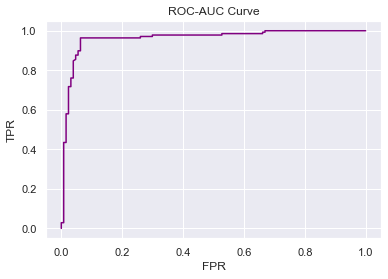

In [114]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='purple')
ax.set_title('ROC-AUC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
plt.show()

In [115]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9623131347711971


***
### 7. Accuracy Threshold Curve.

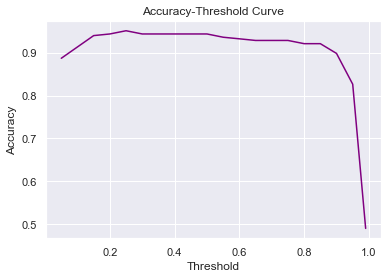

In [116]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [round((y_pred == y_test).sum()/y_pred.shape[0], 4)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('Accuracy-Threshold Curve')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold')
plt.show()

In [117]:
np.max(scores), np.argmax(scores)

(0.9509, 4)

In [118]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.25


***
### 8. F1-Score Threshold Curve.

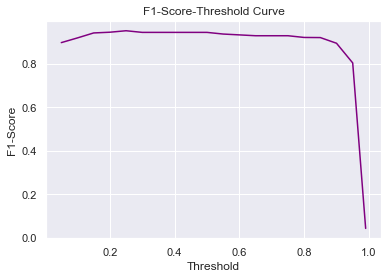

In [119]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
scores = []
for threshold in threshold_list:
    y_pred = np.vectorize(lambda x: 1 if x>threshold else 0)(y_score)
    scores += [f1_score(y_test, y_pred)]
fig, ax = plt.subplots()
ax.plot(threshold_list, scores, color='purple')
ax.set_title('F1-Score-Threshold Curve')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Threshold')
plt.show()

In [120]:
print(f"Area under ROC-AUC curve is {auc(fpr, tpr)}")

Area under ROC-AUC curve is 0.9623131347711971


In [121]:
print(f"Best performing Threshold value is {threshold_list[np.argmax(scores)]}")

Best performing Threshold value is 0.25


***
### 9. Feature Importance.

In [122]:
pd.concat([pd.Series(gbdt_clf.feature_importances_), pd.Series(list(X_train.columns))], axis =1).sort_values(by=0, ascending=False)

,0,1
16,0.882803,reporting_end_month
15,0.059396,reporting_end_year
18,0.014783,joining_month
0,0.008112,age
13,0.006271,reporting_start_year
4,0.006034,end_monthly_income
7,0.005997,total_business
17,0.002787,joining_year
8,0.002735,start_rating
14,0.002145,reporting_start_month


***
***
## **16. Business Insights.**
#### **A.** There are more Male drivers than Female drivers.
#### **B.** 99.7% drivers didn't get income raise or grade raise.
#### **C.** 88.54% of drivers saw their rating getting improved.
#### **D.** 30.67% of drivers left OLA.
#### **E.** Number of drivers joining OLA increased significantly since 2018.
#### **F.** Male drivers have lost more rating compared to Female drives.
#### **G.** Drivers who 
#### **1.** worked for more years with OLA
#### **2.** older in age
#### **3.** have lower education
#### **4.** have very high ratings
#### **5.** generated high total revenue for OLA
#### Saw their income and grade increased significantly compared to other drivers.
#### **H.** Drivers with higher grade and higher ratings left OLA more in numbers compared to other drivers.
#### **I.** Most of the drivers who left OLA had joined OLA in recent years compared other drivers who decided to stay and not leave OLA.
#### **J.** Surprisingly, most of the drivers who left OLA have their last reporting month and year as December 2020.
#### **K.** Test model accuracy achieved for 'Bagging' and 'Boosting' is 95% and 94% respectively.
#### **L.** Area under ROC-AUC curve for 'Bagging' and 'Boosting' is 95% and 96% respectively.
#### **M.** F1-Score is betwwen 95% for both 'Bagging' and 'Boosting' models and for both target labels.
#### **N.** Precision and Recall Scores are between 94% to 96% for both 'Bagging' and 'Boosting' models and for both target labels.
#### **O.** Churning of the drivers is most affected by reporting_end_month, reporting_end_year, joining_month and age in this exact order from highest importance to lowest.

***
***
## **17. Recommendations.**
#### **A.** To predict chrning of the driver, the columns reporting_end_month, reporting_end_year, joining_month and age should be considered.
#### **B.** More data points should be gathered to analyze why many drivers who reported last in December 2020 left OLA.
#### **C.** We saw that the high performing drivers leave more often than the rest. OLA can start a program to reward high performers and recognize their work more often.
#### **D.** OLA can conduct periodic surveys to obtain more data points so as to make prediction model better and more accurate.
#### **F.** We could also see that the drivers who joined OLA recently, left in more numbers. So OLA can focus more on these new drivers to make them stop leaving.